# Jupiter Trojans/Greeks: No-Migration Burn-in (lightweight)

Goal: run a short, no-migration experiment (Sun + Jupiter + low-mass tracers) to see how quickly L4/L5 populations emerge and what burn-in time is needed. This notebook reuses patterns from the migration notebooks (Huayno + Bridge) but keeps the first run lightweight (few thousand tracers).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from amuse.units import units, nbody_system, constants
from amuse.lab import Particles
from amuse.community.huayno.interface import Huayno
from amuse.couple import bridge
from amuse.ext.orbital_elements import orbital_elements_from_binary

%matplotlib inline

/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/support/options.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# --- Tunable parameters for migration ---
N_TRACERS = 2000
A_MIN, A_MAX = 1 | units.AU, 10 | units.AU
BURNIN_TIME = 110_000 | units.yr  # 2 kyr burn-in + 100 kyr migration + small settle
SNAPSHOT_DT = 1000 | units.yr
SNAPSHOT_MIG_STEP = 5_000 | units.yr  # save snapshots every 5 kyr during migration

# Integrator settings
BRIDGE_DT = 0.05 | units.yr
HUAYNO_WORKERS = 1
HUAYNO_TSTEP_PARAM = 0.01
TROJAN_INIT = True

# Migration parameters (outward drift via type-II-like torque)
JUPITER_A_INIT = 4.8 | units.AU
JUPITER_A_FINAL = 5.2 | units.AU
T_START_JUMP = 2_000 | units.yr   # start migration after burn-in
T_JUMP_STOP  = 102_000 | units.yr # finish migration by +100 kyr
TAU_A = -1.316e6 | units.yr       # outward: calibrated ~4.8->5.2 over 100 kyr
TAU_E = 6.58e5  | units.yr        # optional e-damping (|tau_a|/2)

JUPITER_E = 0.0
JUPITER_M = 1.0 | units.MJupiter
SUN_M = 1.0 | units.MSun

np.random.seed(2)


In [3]:
def make_massive_bodies():
    bodies = Particles(2)
    bodies[0].mass = SUN_M
    bodies[0].name = "Sun"
    bodies[0].radius = 1 | units.RSun

    bodies[1].mass = JUPITER_M
    bodies[1].name = "Jupiter"
    bodies[1].radius = 1 | units.RJupiter

    bodies.position = (0, 0, 0) | units.AU
    bodies.velocity = (0, 0, 0) | (units.AU/units.yr)

    mu = constants.G * (SUN_M + JUPITER_M)
    v_circ = (mu / JUPITER_A_INIT).sqrt().as_quantity_in(units.AU/units.yr)
    bodies[1].x = JUPITER_A_INIT
    bodies[1].vy = v_circ
    bodies[0].x = 0 | units.AU
    bodies[0].vy = -(v_circ * JUPITER_M / SUN_M)
    bodies.move_to_center()
    return bodies

def make_tracer_disk(n=N_TRACERS, a_min=A_MIN, a_max=A_MAX):
    tracers = Particles(n)
    tracers.mass = 0 | units.kg
    tracers.name = "tracer"

    if TROJAN_INIT:
        # Initialize Trojans with realistic libration amplitudes
        a_vals = JUPITER_A_INIT * (1 + 0.02*np.random.randn(n))
        lam0 = np.deg2rad(60)
        lam = np.where(np.arange(n) < n/2,
                       lam0 + np.deg2rad(20)*np.random.randn(n),
                       -lam0 + np.deg2rad(20)*np.random.randn(n)) | units.rad
        tracers.a = a_vals
        tracers.e = np.random.uniform(0.0, 0.05, n)
        tracers.inc = np.random.uniform(0.0, 5.0, n) | units.deg
        for i, p in enumerate(tracers):
            r = p.a
            theta_rad = lam[i].value_in(units.rad)
            x = r * np.cos(theta_rad)
            y = r * np.sin(theta_rad)
            v_circ = (constants.G * SUN_M / r).sqrt().as_quantity_in(units.AU/units.yr)
            vx = -v_circ * np.sin(theta_rad)
            vy =  v_circ * np.cos(theta_rad)
            p.position = (x, y, 0 | units.AU)
            p.velocity = (vx, vy, 0 | (units.AU/units.yr))
        return tracers

    u = np.random.uniform(0, 1, n)
    a_vals = a_min * (a_max/a_min)**u
    tracers.a = a_vals
    tracers.e = np.random.uniform(0.0, 0.02, n)
    tracers.inc = np.random.uniform(0.0, 2.0, n) | units.deg

    M = np.random.uniform(0, 2*np.pi, n) | units.rad
    for i, p in enumerate(tracers):
        r = p.a
        theta_rad = M[i].value_in(units.rad)
        x = r * np.cos(theta_rad)
        y = r * np.sin(theta_rad)
        v_circ = (constants.G * SUN_M / r).sqrt().as_quantity_in(units.AU/units.yr)
        vx = -v_circ * np.sin(theta_rad)
        vy =  v_circ * np.cos(theta_rad)
        p.position = (x, y, 0 | units.AU)
        p.velocity = (vx, vy, 0 | (units.AU/units.yr))
    return tracers


In [4]:
def setup_codes(massive_bodies):
    Porb = 2*np.pi * (JUPITER_A_INIT**3/(constants.G*(SUN_M+JUPITER_M))).sqrt()
    converter = nbody_system.nbody_to_si(massive_bodies.mass.sum(), Porb)
    gravity_massive = Huayno(converter, number_of_workers=HUAYNO_WORKERS)
    gravity_massive.parameters.timestep_parameter = HUAYNO_TSTEP_PARAM
    gravity_massive.parameters.inttype_parameter = 13
    gravity_massive.parameters.epsilon_squared = (1e-6 | units.AU**2)
    gravity_massive.particles.add_particles(massive_bodies)
    return gravity_massive, converter


In [5]:
# Jupiter migration code (type-II-like) for Bridge
from amuse.couple import bridge

class JupiterMigrationCode:
    """Apply type-II-like migration kicks to Jupiter.
    Positive tau_a: inward. Negative tau_a: outward.
    tau_e optional eccentricity damping.
    This is a simple kick-only code that doesn't wrap any gravity solver.
    """
    def __init__(self, particles, jupiter_index=1):
        self.particles = particles
        self.jupiter_index = jupiter_index
        self.tau_a = None
        self.tau_e = None
        self.enable_migration = False
        self.timestep = 0.1 | units.yr
        
    def evolve_model(self, tend):
        # Bridge will call this but we do nothing here
        # All work is done in kick()
        pass
    
    def kick(self, dt):
        if not self.enable_migration:
            return 0 | units.J
            
        jup = self.particles[self.jupiter_index]
        v = jup.velocity
        vmag = v.length()
        de = 0 | units.J
        if vmag == 0 | (units.AU/units.yr):
            return de
        v_hat = v / vmag
        
        # Migration: dv/dt = -v/(2*tau_a) (tau_a<0 => outward)
        if self.tau_a is not None and self.tau_a != 0 | units.yr:
            a_mig = -(v_hat * (vmag / (2*self.tau_a)))
            jup.velocity += a_mig * dt
            
        # Ecc damping: dv_rad/dt = -v_rad/tau_e
        if self.tau_e is not None and self.tau_e != 0 | units.yr:
            r_hat = jup.position / jup.position.length()
            v_rad = (v * r_hat).sum() * r_hat
            a_damp = -(v_rad / self.tau_e)
            jup.velocity += a_damp * dt
            
        return de




In [6]:
def apply_jupiter_jump(massive_bodies, gravity_massive, t):
    return


In [7]:
import sys

def evolve_with_tracers(massive_bodies, tracers, bridge_massive, gravity_massive):
    times = [] | units.yr
    ratios = []
    n4s = []
    n5s = []
    jup_xs = []
    jup_ys = []
    snapshots = []
    t = 0 | units.yr
    t_end = BURNIN_TIME
    eps = 1e-9 | units.m**3

    def compute_acc(r_tr, r_mb, m_mb):
        dr = r_tr[:, None, :] - r_mb[None, :, :]
        r2 = (dr**2).sum(axis=2)
        r = r2.sqrt()
        r3 = r**3 + eps
        return (-constants.G * m_mb[None,:,None] * dr / r3[:,:,None]).sum(axis=1)

    next_output = 0 | units.yr
    burnin_mark = T_START_JUMP
    migration_next = T_START_JUMP
    channel_to_massive = gravity_massive.particles.new_channel_to(massive_bodies)
    progress_step = 5
    next_progress = progress_step
    migration_active = False  # Track if migration has been enabled

    while t < t_end:
        dt_step = min(BRIDGE_DT, t_end - t)
        bridge_massive.evolve_model(t + dt_step)
        channel_to_massive.copy()

        r_tr = (np.column_stack([
            tracers.x.value_in(units.m),
            tracers.y.value_in(units.m),
            tracers.z.value_in(units.m),
        ]) | units.m)
        v_tr = (np.column_stack([
            tracers.vx.value_in(units.m/units.s),
            tracers.vy.value_in(units.m/units.s),
            tracers.vz.value_in(units.m/units.s),
        ]) | (units.m/units.s))
        r_mb = (np.column_stack([
            massive_bodies.x.value_in(units.m),
            massive_bodies.y.value_in(units.m),
            massive_bodies.z.value_in(units.m),
        ]) | units.m)
        m_mb = (np.array(massive_bodies.mass.value_in(units.kg)) | units.kg)

        dt_si = dt_step.as_quantity_in(units.s)
        acc = compute_acc(r_tr, r_mb, m_mb)
        v_tr += 0.5 * acc * dt_si
        r_tr += v_tr * dt_si
        acc2 = compute_acc(r_tr, r_mb, m_mb)
        v_tr += 0.5 * acc2 * dt_si

        tracers.x = (r_tr[:,0]).as_quantity_in(units.AU)
        tracers.y = (r_tr[:,1]).as_quantity_in(units.AU)
        tracers.z = (r_tr[:,2]).as_quantity_in(units.AU)
        tracers.vx = (v_tr[:,0]).as_quantity_in(units.AU/units.yr)
        tracers.vy = (v_tr[:,1]).as_quantity_in(units.AU/units.yr)
        tracers.vz = (v_tr[:,2]).as_quantity_in(units.AU/units.yr)

        t += dt_step

        # Enable migration when reaching T_START_JUMP
        if not migration_active and t >= T_START_JUMP:
            if hasattr(bridge_massive, 'partners') and len(bridge_massive.partners) > 1:
                # Find migration code in bridge partners
                for partner in bridge_massive.partners:
                    if hasattr(partner, 'enable_migration'):
                        partner.enable_migration = True
                        migration_active = True
                        jup = massive_bodies[massive_bodies.name=="Jupiter"][0]
                        jup_a = jup.position.length().value_in(units.AU)
                        print(f"\n[Migration enabled at t={t.value_in(units.kyr):.2f} kyr, Jupiter a={jup_a:.3f} AU]")
                        break

        t_end_yr = t_end.value_in(units.yr)
        t_yr = t.value_in(units.yr)
        progress = (t_yr/t_end_yr)*100 if t_end_yr>0 else 100
        if progress >= next_progress or t >= t_end:
            t_kyr = t.value_in(units.kyr)
            jup = massive_bodies[massive_bodies.name=="Jupiter"][0]
            jup_a = jup.position.length().value_in(units.AU)
            sys.stdout.write(f'\rProgress: {progress:.1f}% (t={t_kyr:.2f} kyr, Jupiter a={jup_a:.4f} AU)')
            sys.stdout.flush()
            next_progress += progress_step

        save_now = False
        if t >= next_output - 0.5*dt_step:
            save_now = True
            next_output += SNAPSHOT_DT
        if t >= burnin_mark - 0.5*dt_step and burnin_mark >= 0|units.yr:
            save_now = True
            burnin_mark = -1|units.yr
        if t >= migration_next - 0.5*dt_step and t >= T_START_JUMP:
            save_now = True
            migration_next += SNAPSHOT_MIG_STEP

        if save_now:
            n4, n5 = compute_trojan_counts(massive_bodies, tracers)
            total = n4 + n5
            ratios.append(n4/total if total > 0 else np.nan)
            n4s.append(n4)
            n5s.append(n5)
            jup = massive_bodies[massive_bodies.name=="Jupiter"][0]
            jup_xs.append(jup.x.value_in(units.AU))
            jup_ys.append(jup.y.value_in(units.AU))
            snapshots.append((tracers.x.value_in(units.AU), tracers.y.value_in(units.AU)))
            times.append(t)

    print()  # Final newline after progress
    return times, np.array(ratios), np.array(n4s), np.array(n5s), snapshots, np.array(jup_xs), np.array(jup_ys)

def compute_trojan_counts(massive_bodies, tracers):
    jup = massive_bodies[massive_bodies.name == 'Jupiter'][0]
    lambda_j = np.arctan2(jup.y.value_in(units.AU), jup.x.value_in(units.AU))
    a_j = (jup.position.length())
    dlam = []
    is_coorb = []
    for p in tracers:
        lam = np.arctan2(p.y.value_in(units.AU), p.x.value_in(units.AU))
        d = np.arctan2(np.sin(lam - lambda_j), np.cos(lam - lambda_j))
        dlam.append(d)
        is_coorb.append(abs(p.position.length()/a_j - 1) < 0.07)
    dlam = np.array(dlam)
    is_coorb = np.array(is_coorb)
    L4 = (dlam > np.deg2rad(60-25)) & (dlam < np.deg2rad(60+25)) & is_coorb
    L5 = (dlam < np.deg2rad(-60+25)) & (dlam > np.deg2rad(-60-25)) & is_coorb
    return L4.sum(), L5.sum()

def compute_trojan_ratio(massive_bodies, tracers):
    n4, n5 = compute_trojan_counts(massive_bodies, tracers)
    total = n4 + n5
    return n4/total if total > 0 else np.nan


Progress: 100.0% (t=110.00 kyr, Jupiter a=4.7975 AU)



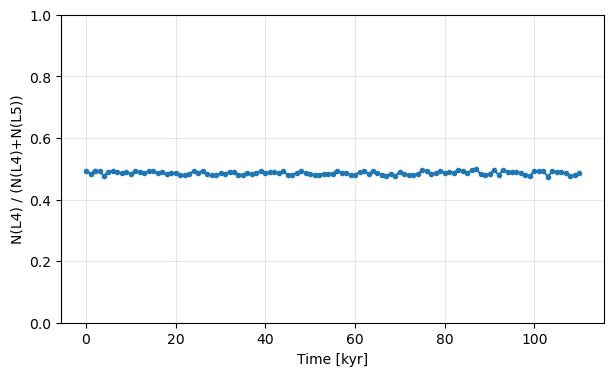

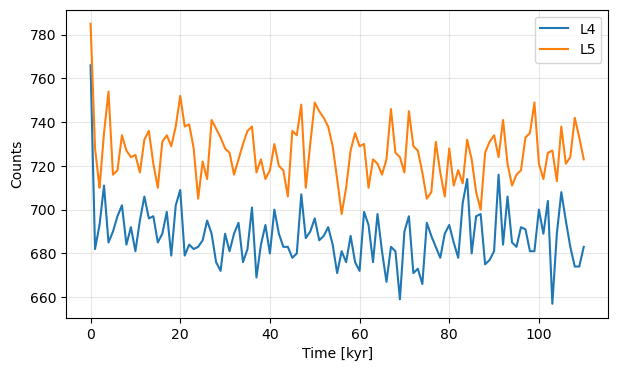

In [8]:
massive_bodies = make_massive_bodies()
tracers = make_tracer_disk()
gravity_massive, converter = setup_codes(massive_bodies)

# Build migration bridge (migration disabled initially, enabled at T_START_JUMP)
migration_code = JupiterMigrationCode(massive_bodies, jupiter_index=1)
migration_code.timestep = BRIDGE_DT
migration_code.tau_a = TAU_A
migration_code.tau_e = TAU_E if TAU_E != 0 | units.yr else None
migration_code.enable_migration = False  # Start with migration disabled

bridge_massive = bridge.Bridge()
bridge_massive.add_system(gravity_massive)
bridge_massive.add_code(migration_code)
bridge_massive.timestep = BRIDGE_DT

times, ratios, n4s, n5s, snapshots, jup_xs, jup_ys = evolve_with_tracers(massive_bodies, tracers, bridge_massive, gravity_massive)

plt.figure(figsize=(7,4))
plt.plot(np.array([t.value_in(units.kyr) for t in times]), ratios, marker='o', ms=3)
plt.xlabel('Time [kyr]')
plt.ylabel('N(L4) / (N(L4)+N(L5))')
plt.ylim(0,1)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(np.array([t.value_in(units.kyr) for t in times]), n4s, label='L4')
plt.plot(np.array([t.value_in(units.kyr) for t in times]), n5s, label='L5')
plt.xlabel('Time [kyr]')
plt.ylabel('Counts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
# Save run data
import os, numpy as np
os.makedirs('simulation_data', exist_ok=True)
np.savez_compressed('simulation_data/no_migration_outward.npz',
    times_yr=np.array([t.value_in(units.yr) for t in times]),
    ratios=np.array(ratios),
    n4s=np.array(n4s),
    n5s=np.array(n5s),
    jup_xs=np.array(jup_xs),
    jup_ys=np.array(jup_ys)
)
print('Saved to simulation_data/no_migration_burnin.npz')


Saved to simulation_data/no_migration_burnin.npz


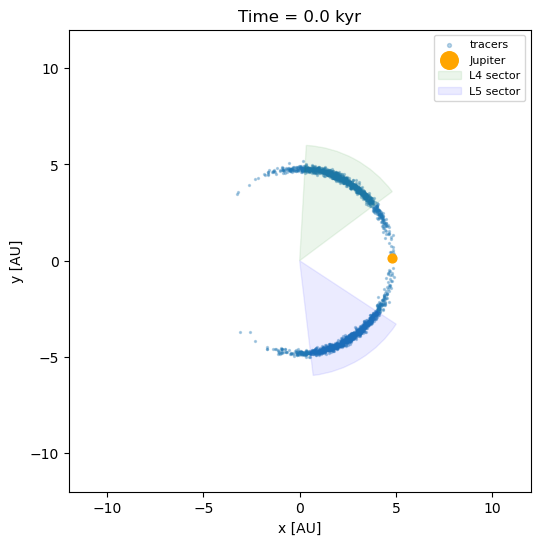

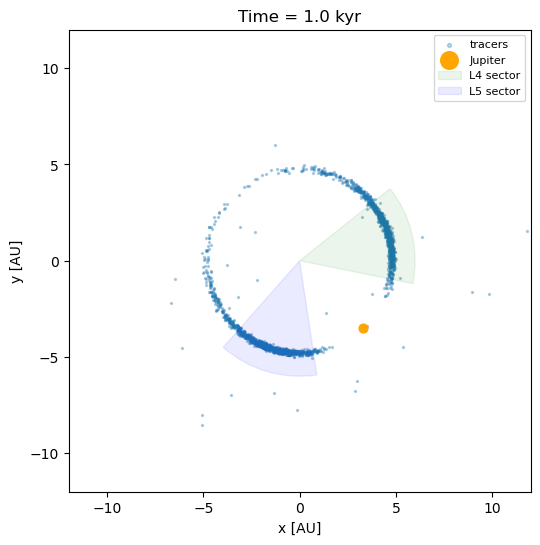

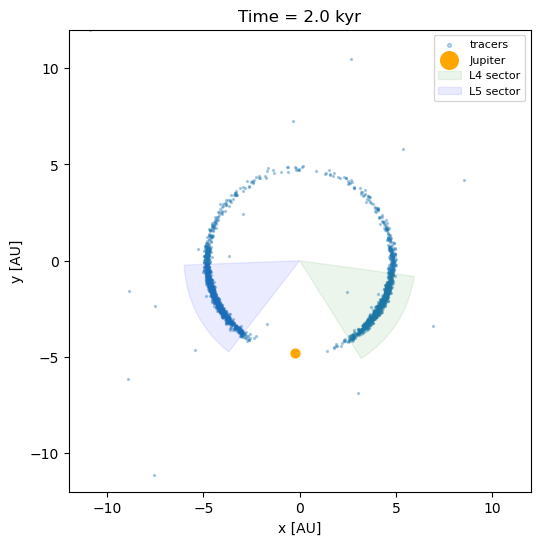

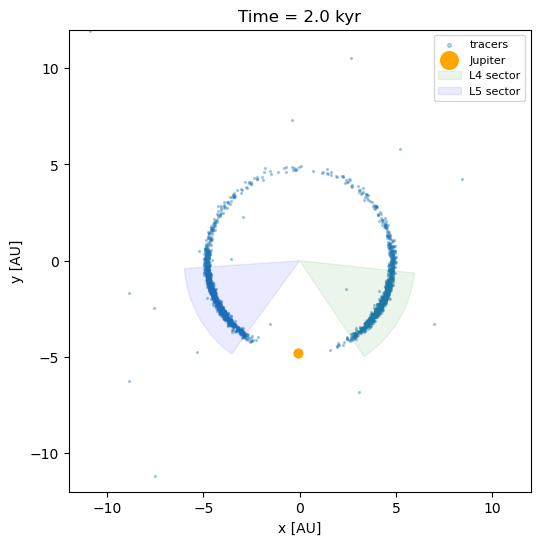

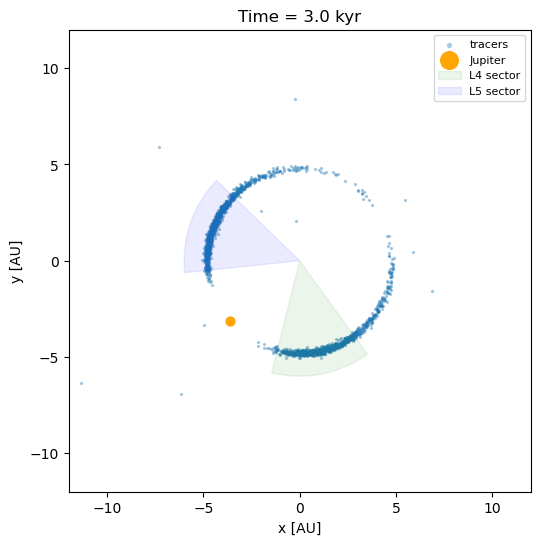

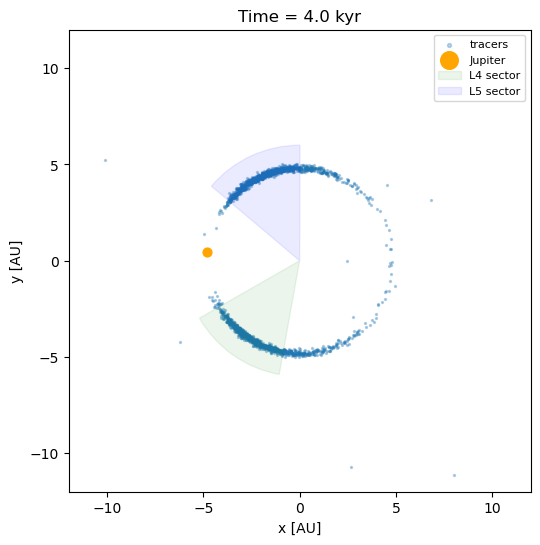

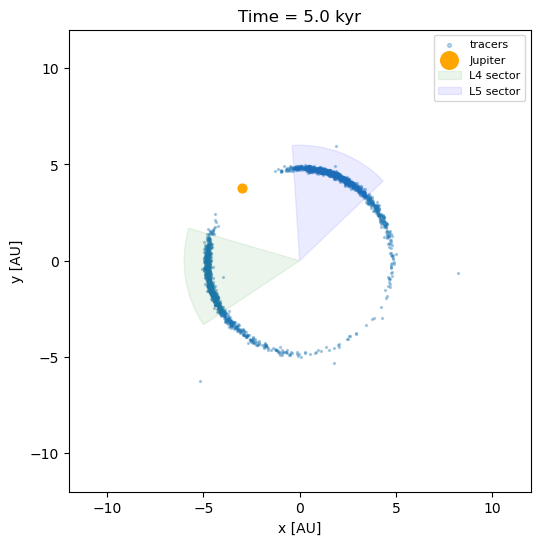

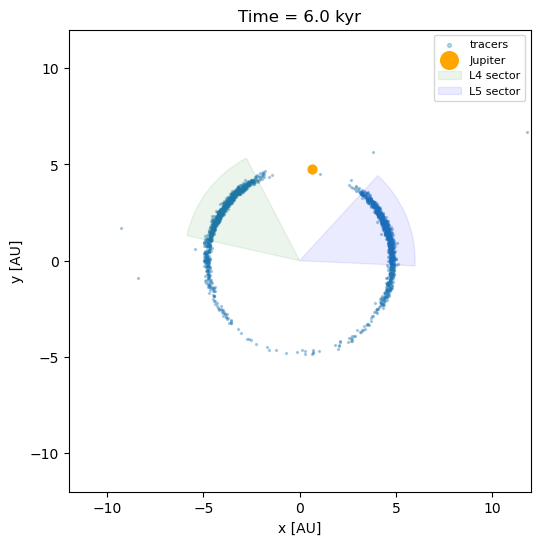

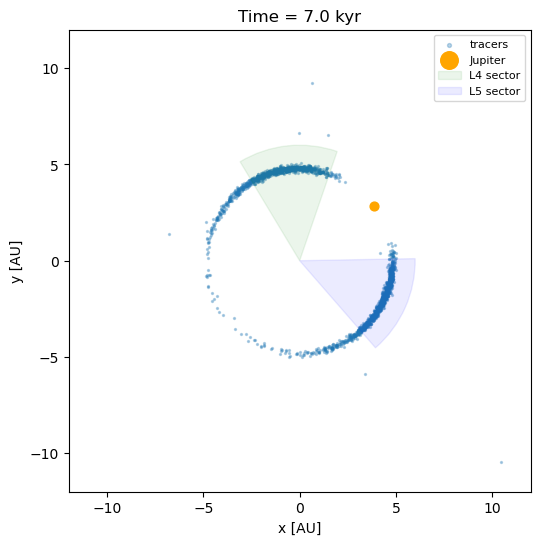

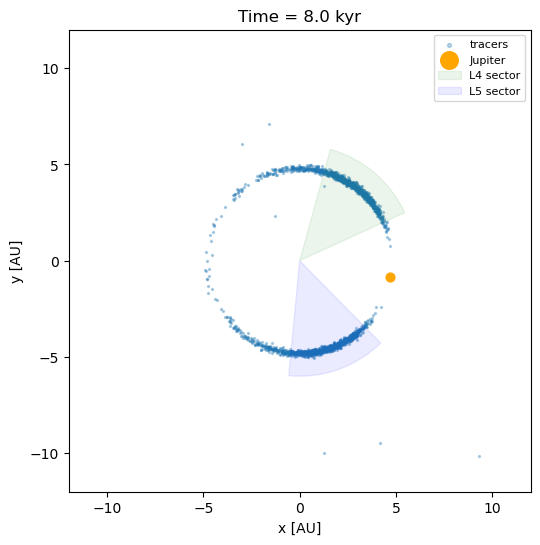

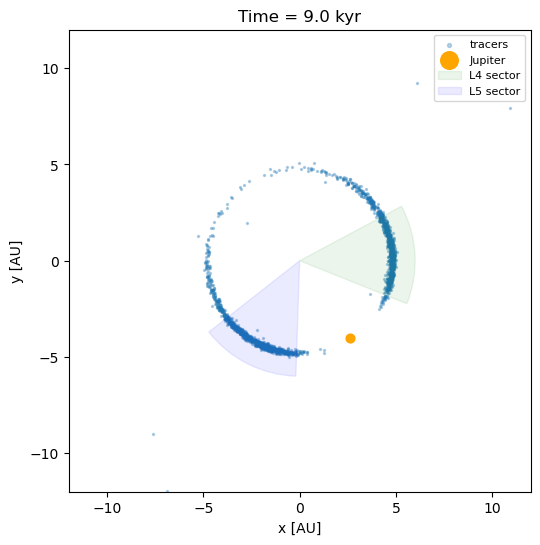

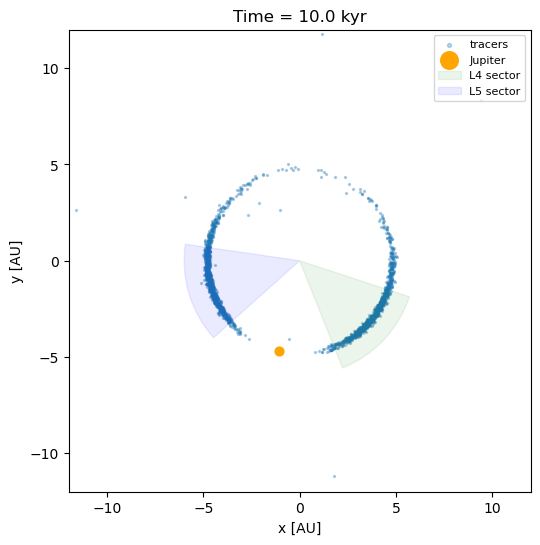

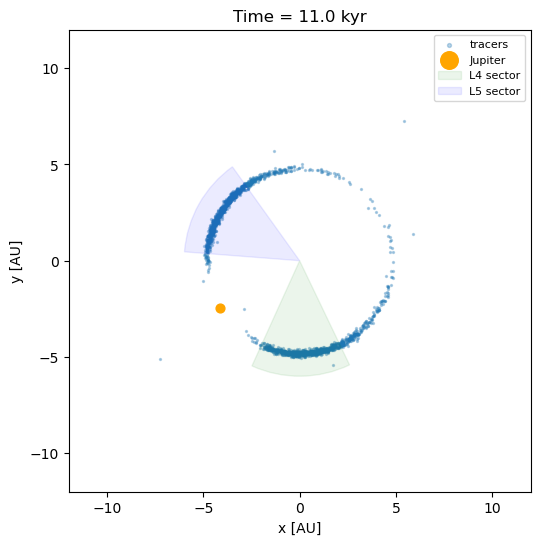

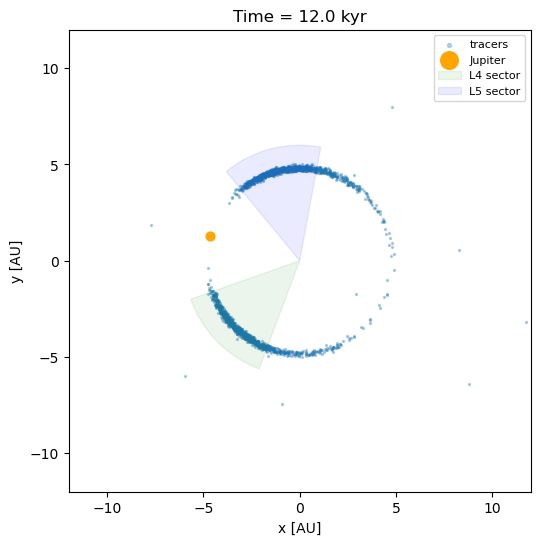

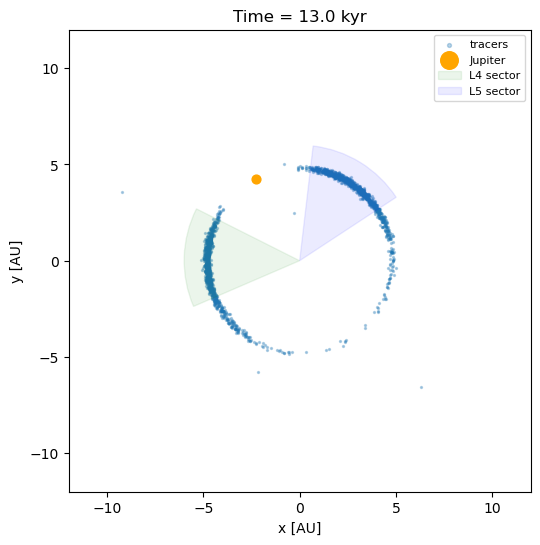

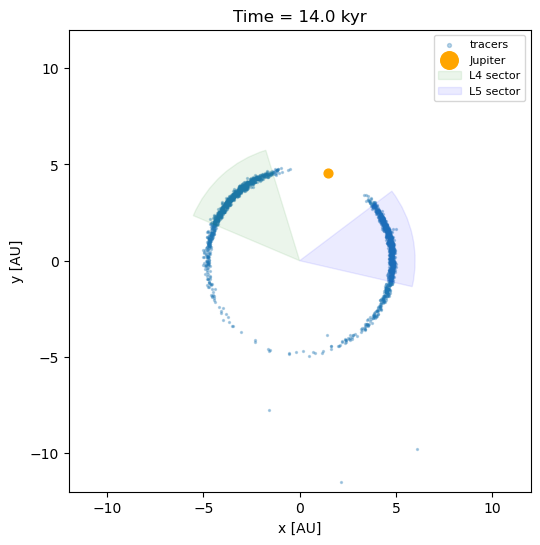

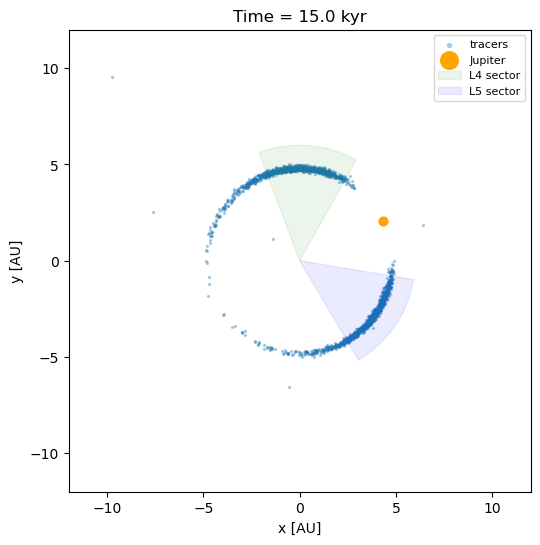

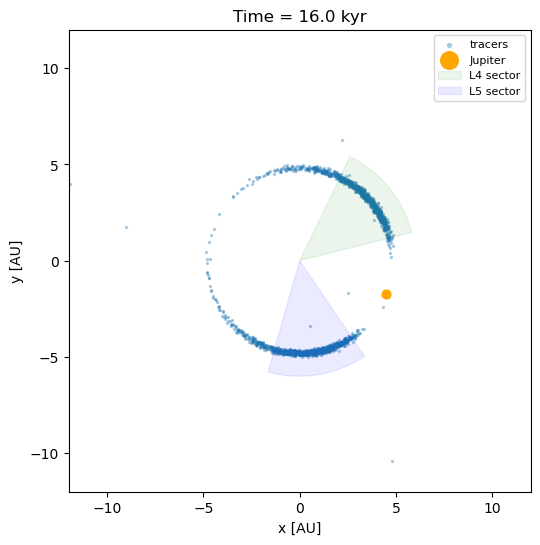

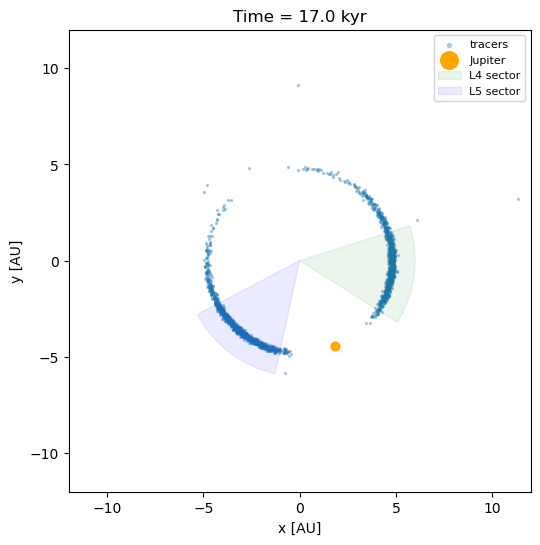

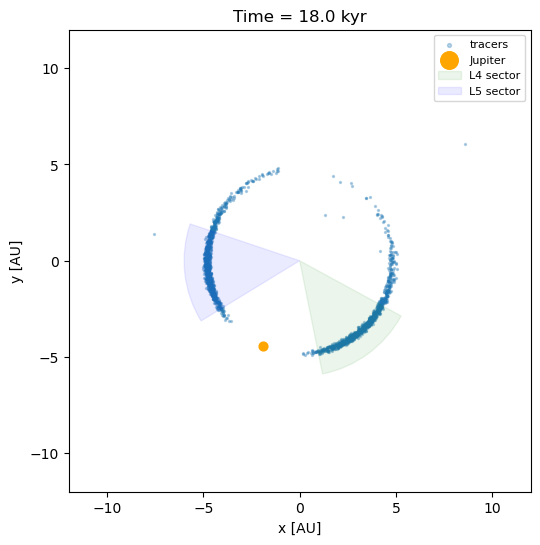

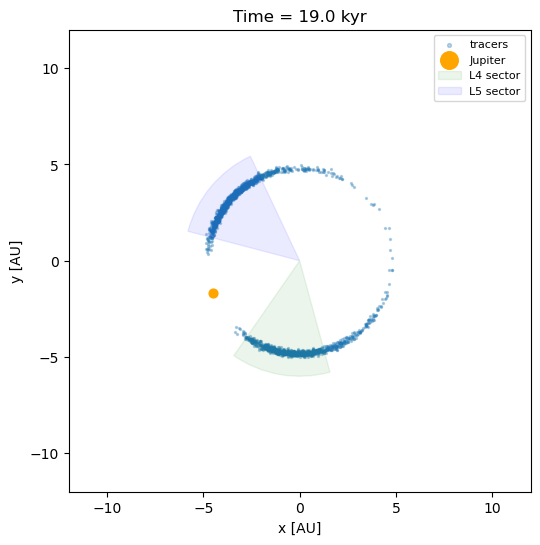

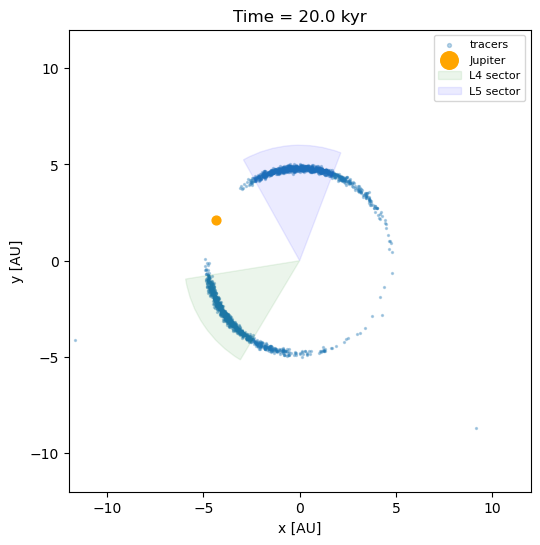

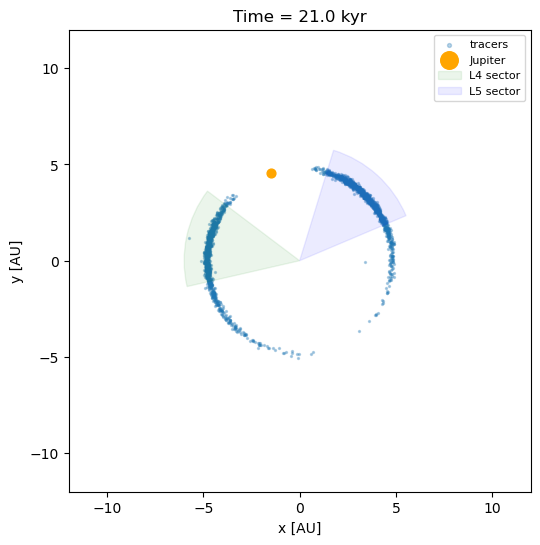

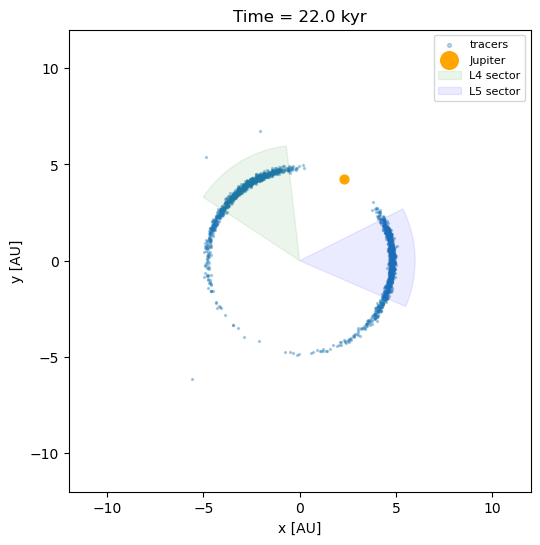

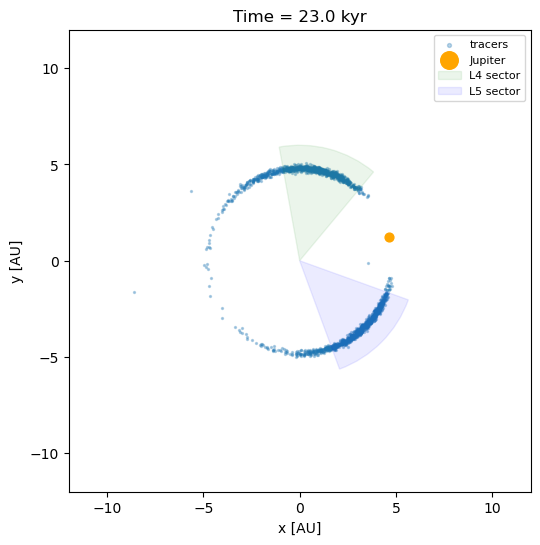

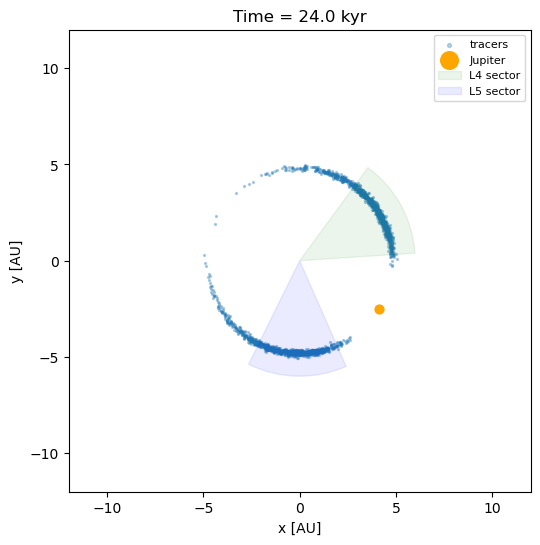

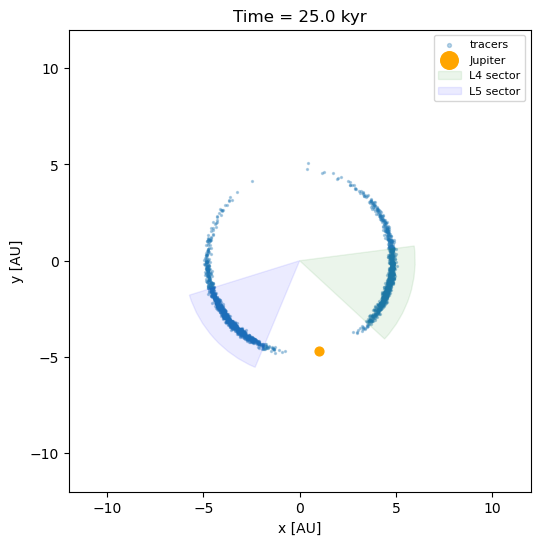

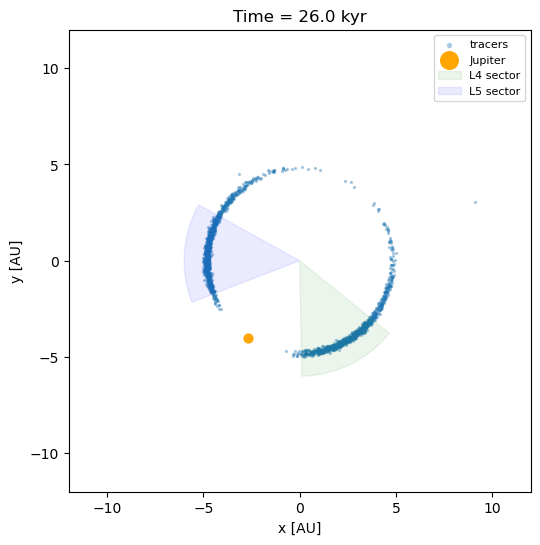

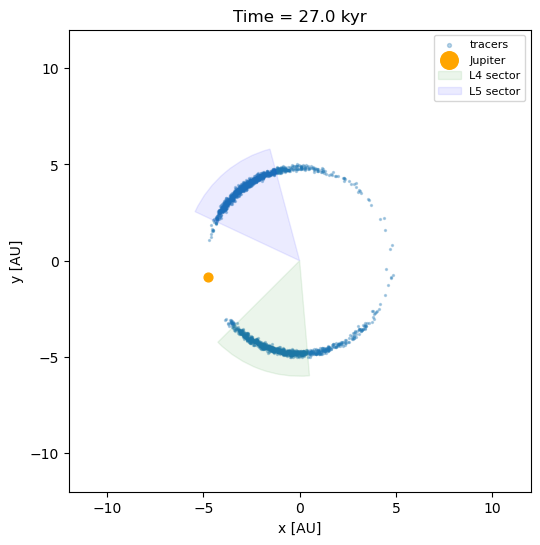

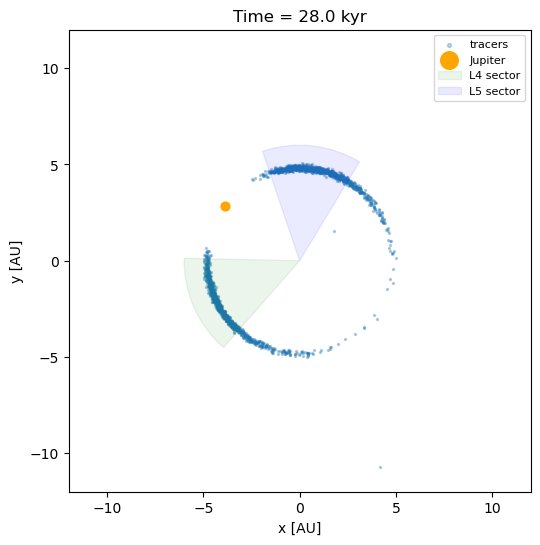

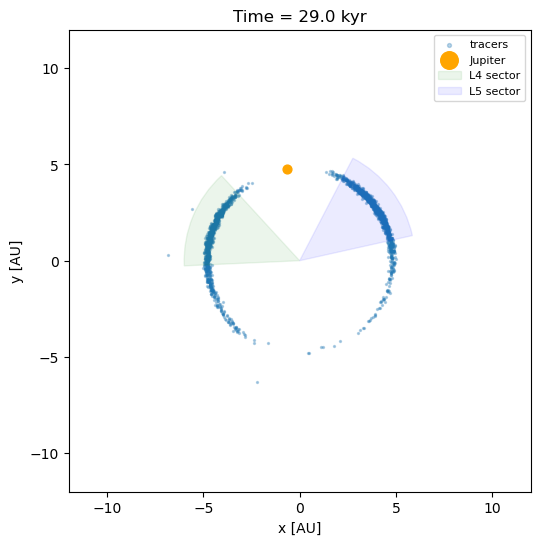

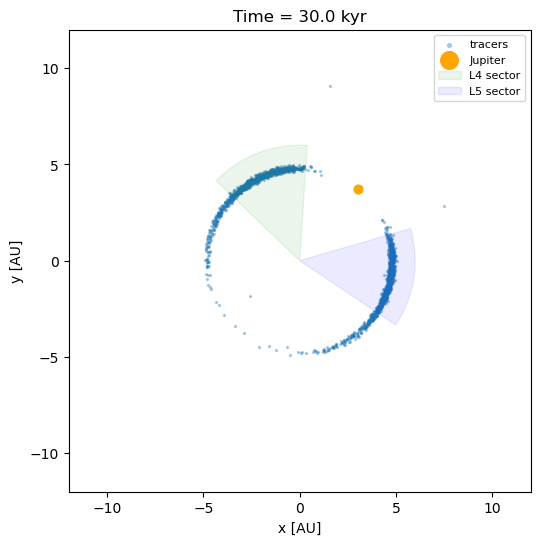

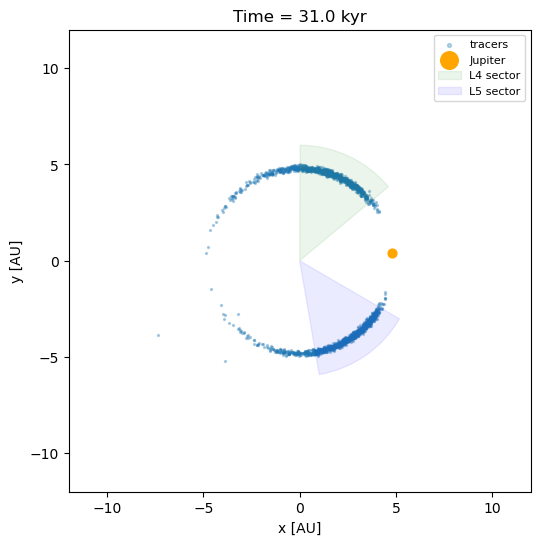

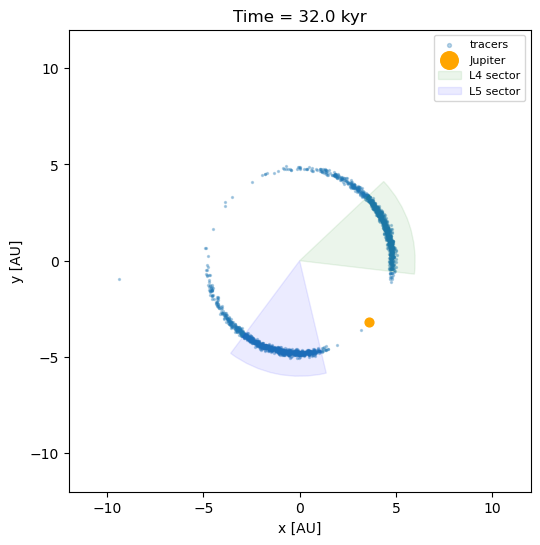

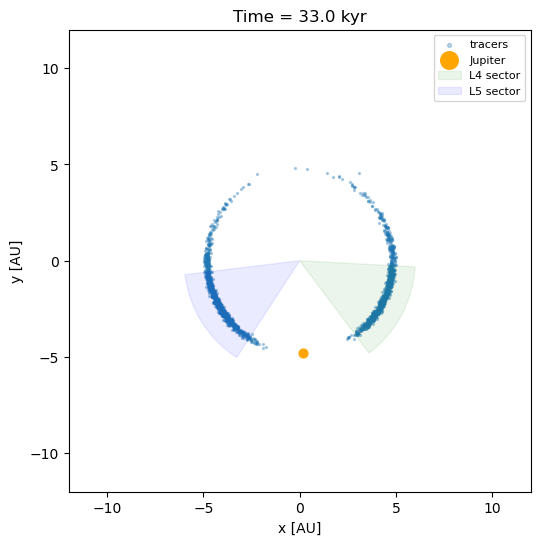

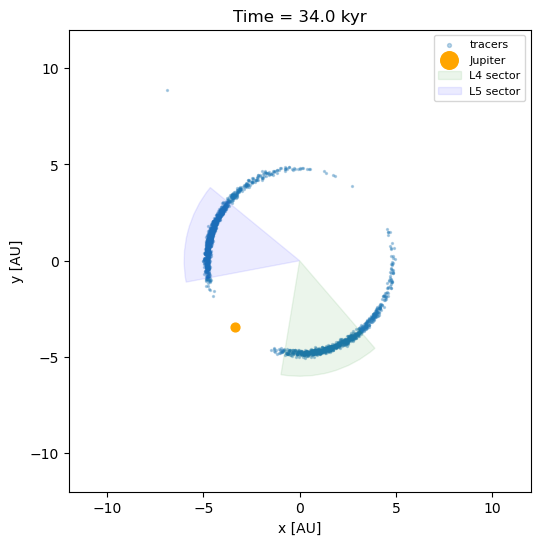

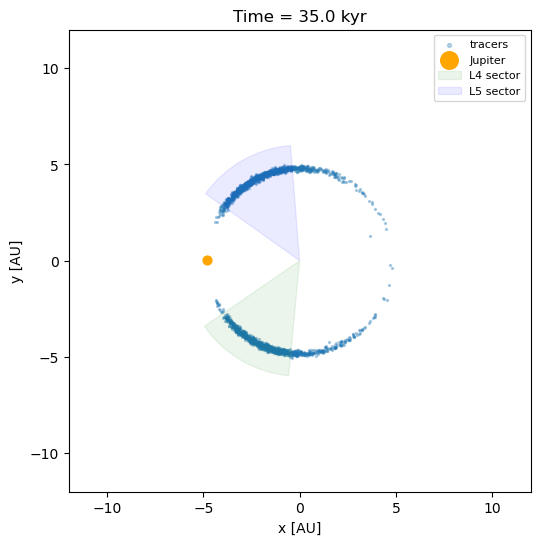

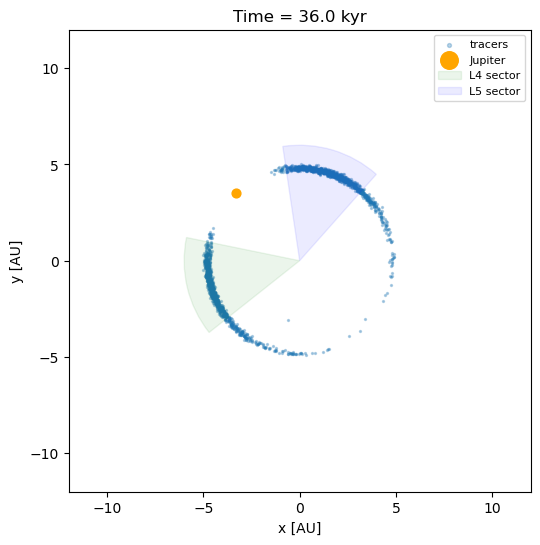

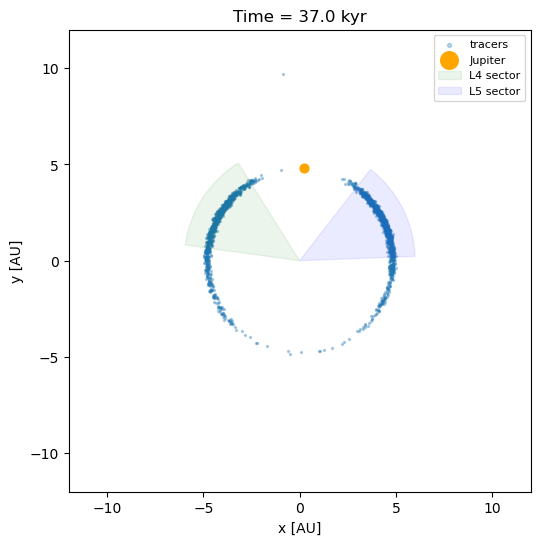

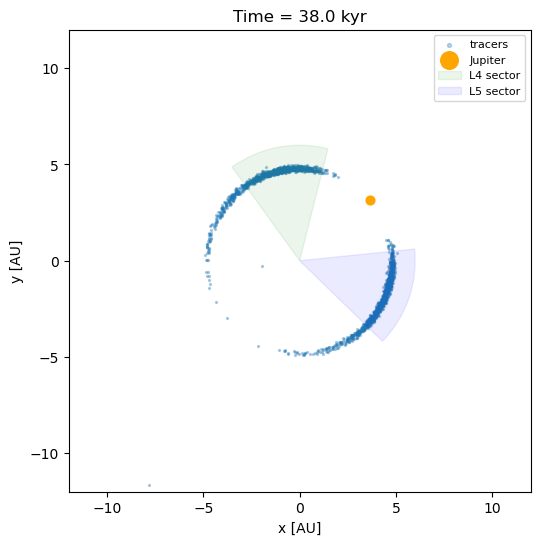

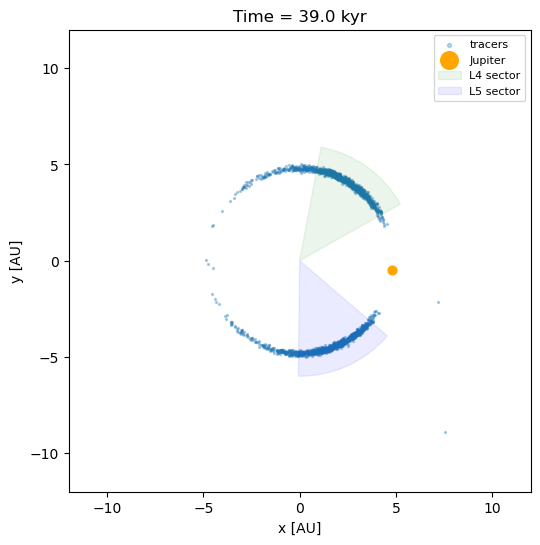

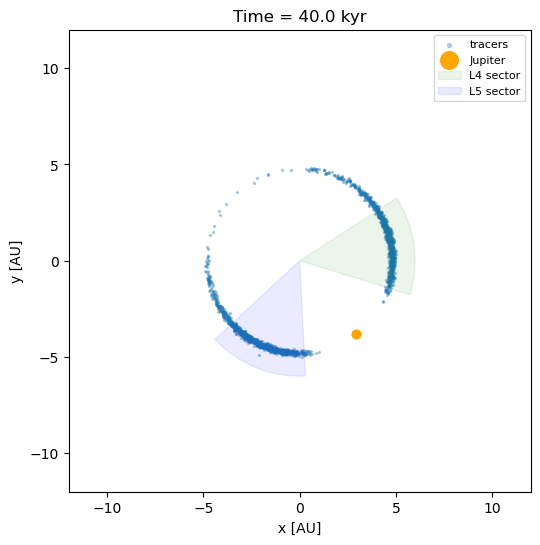

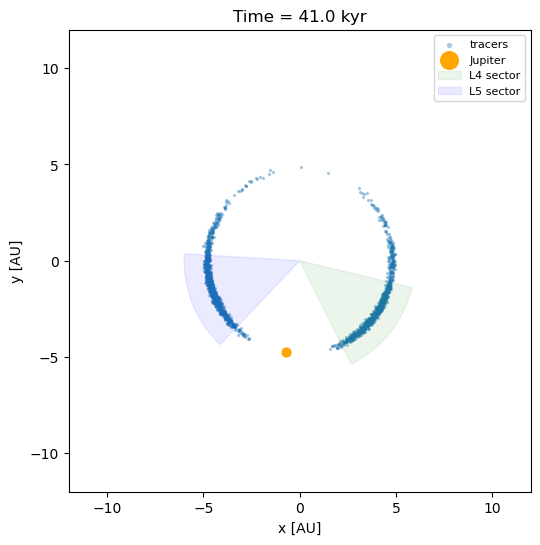

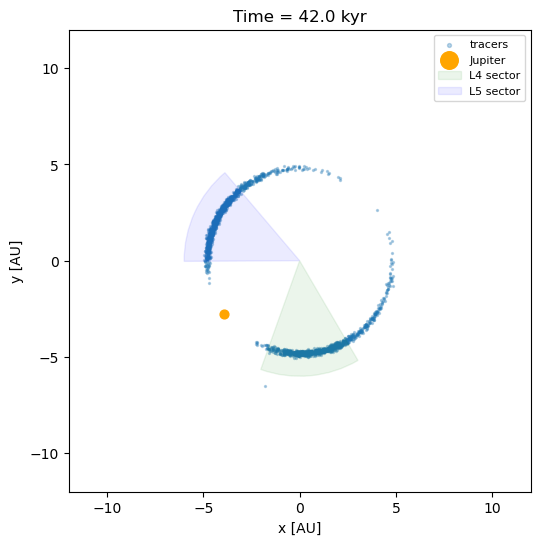

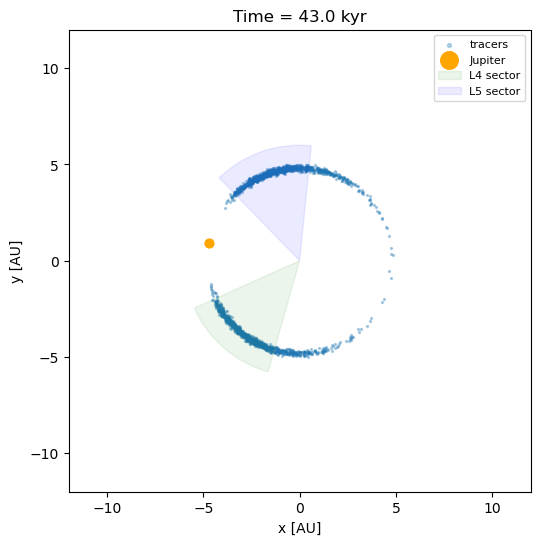

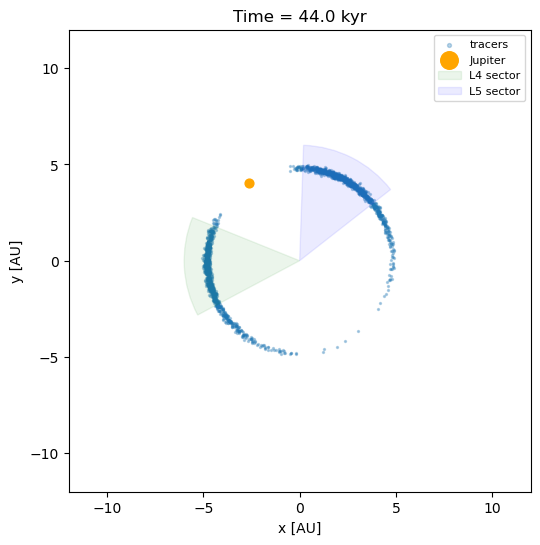

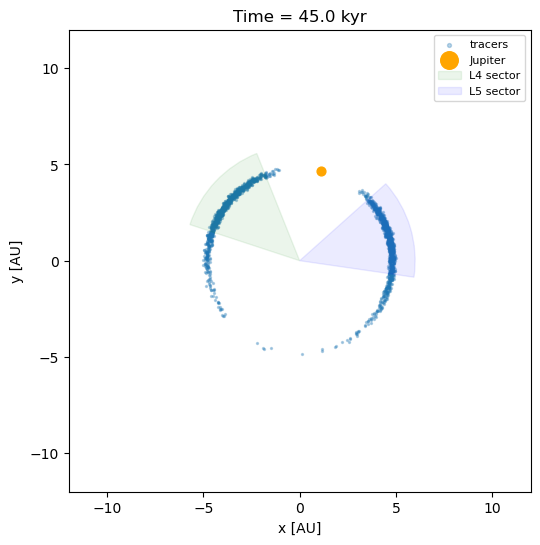

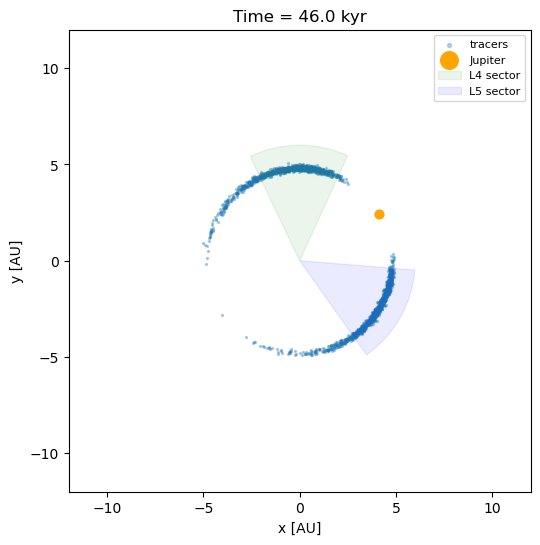

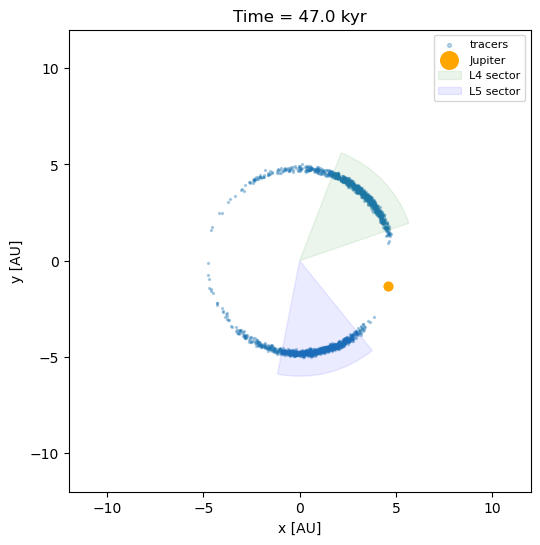

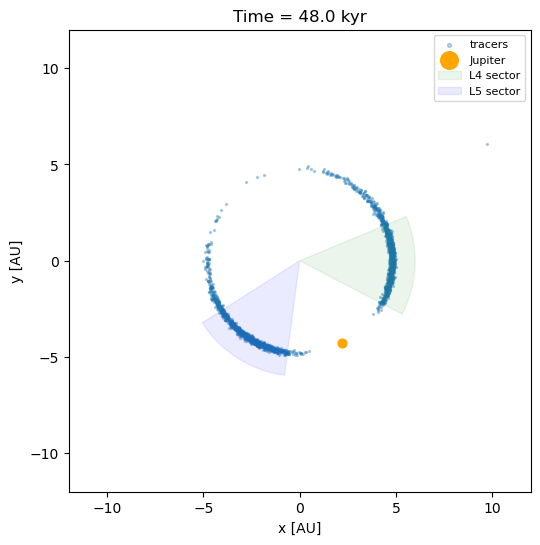

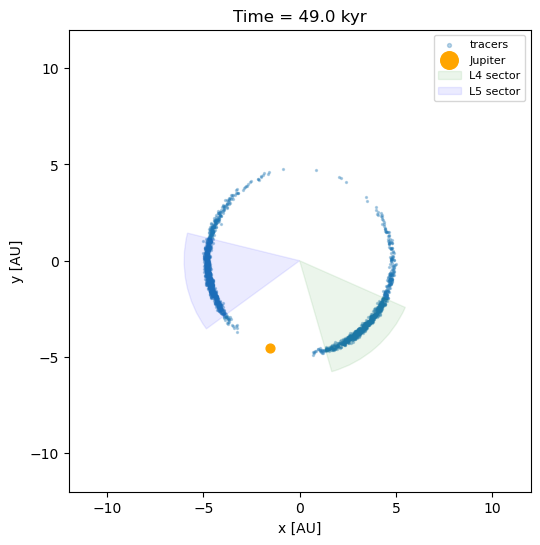

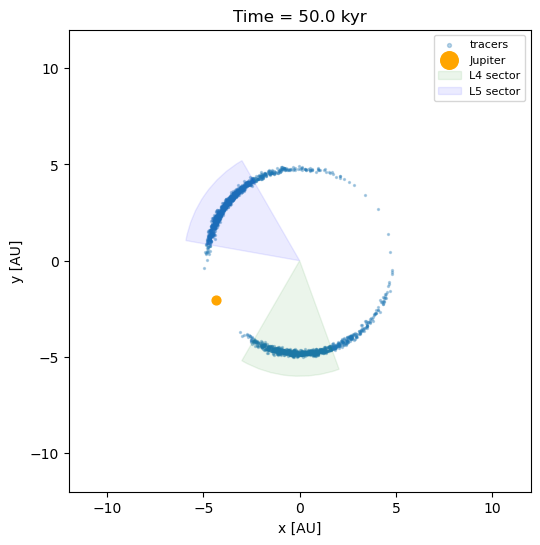

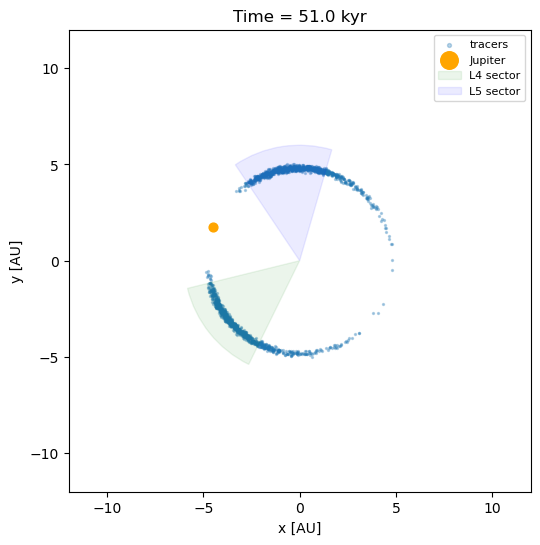

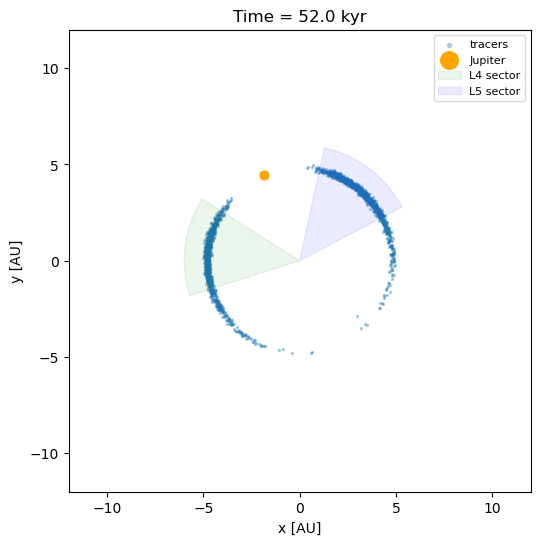

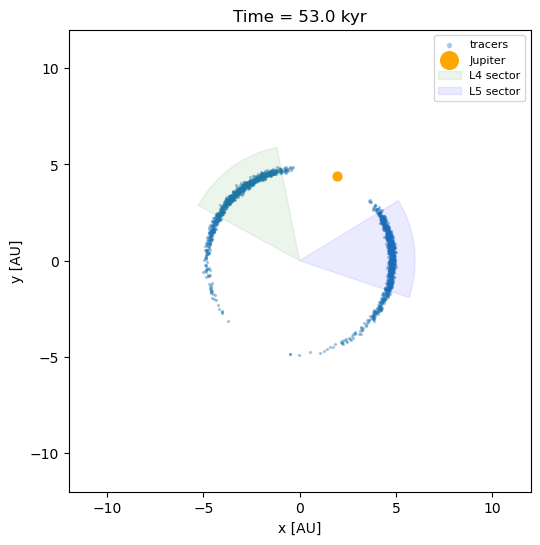

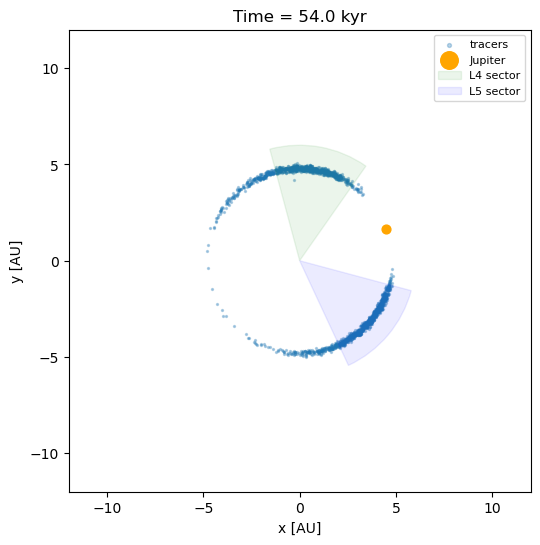

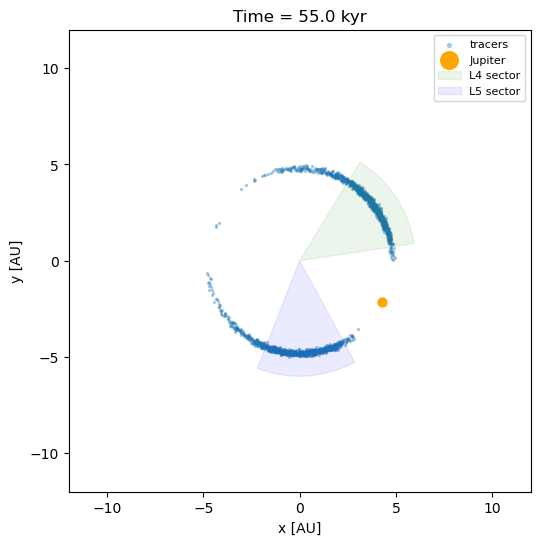

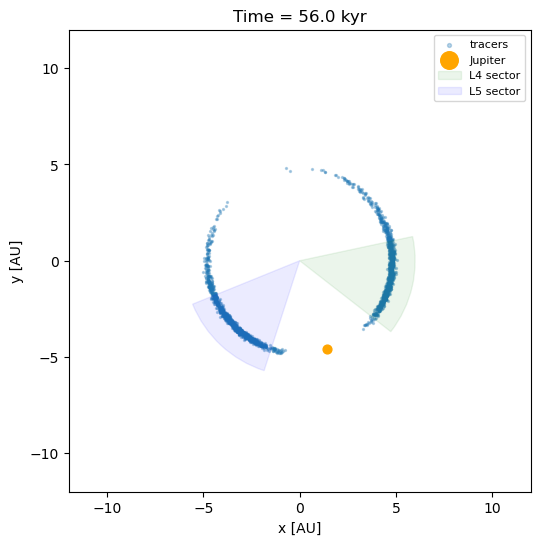

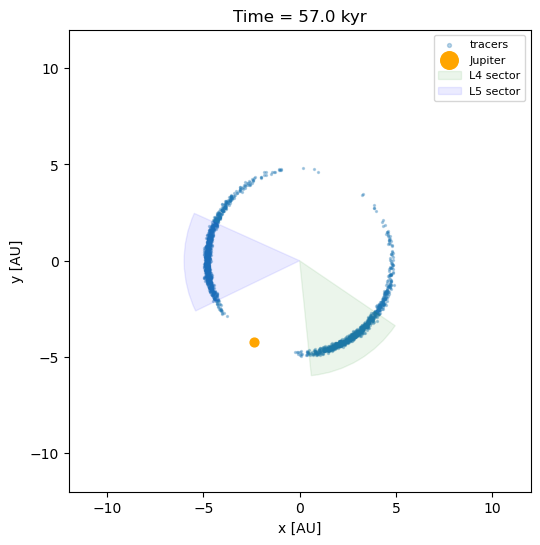

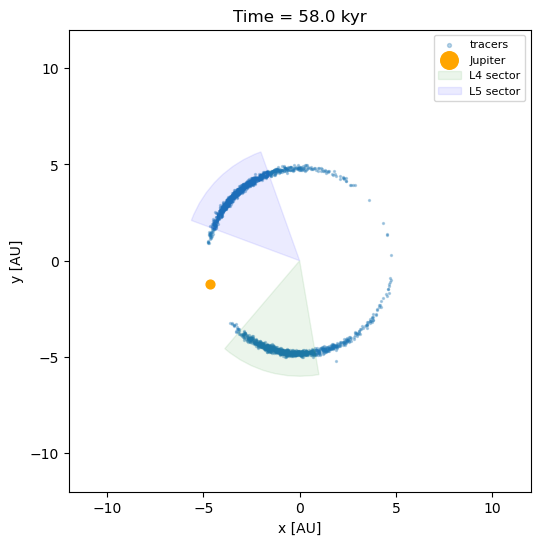

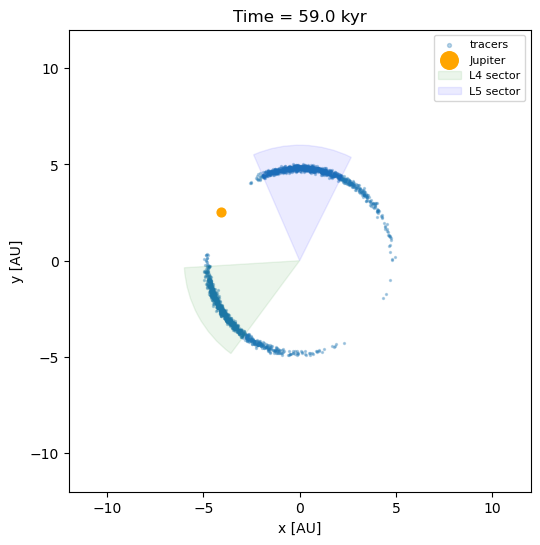

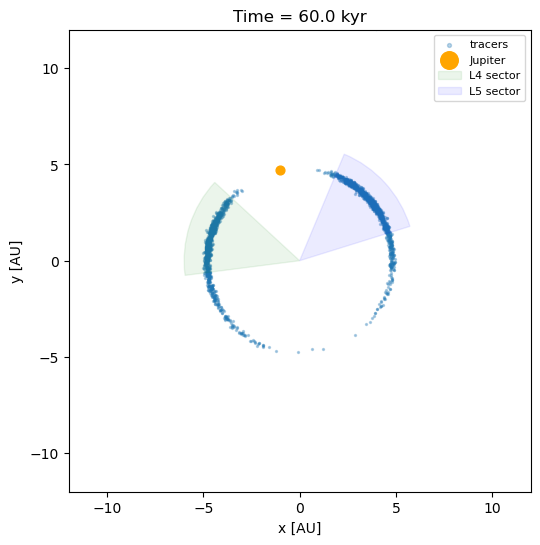

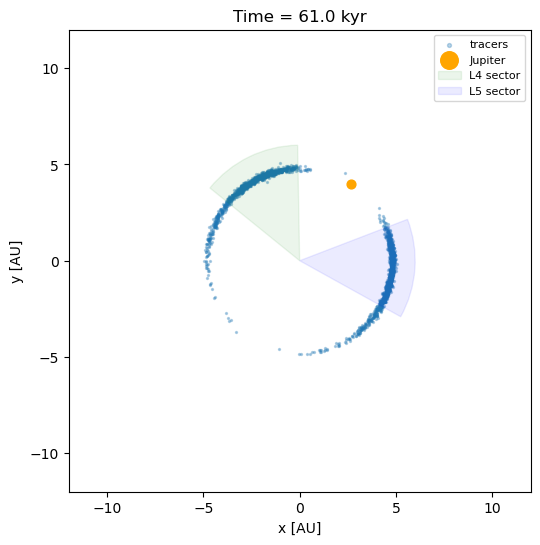

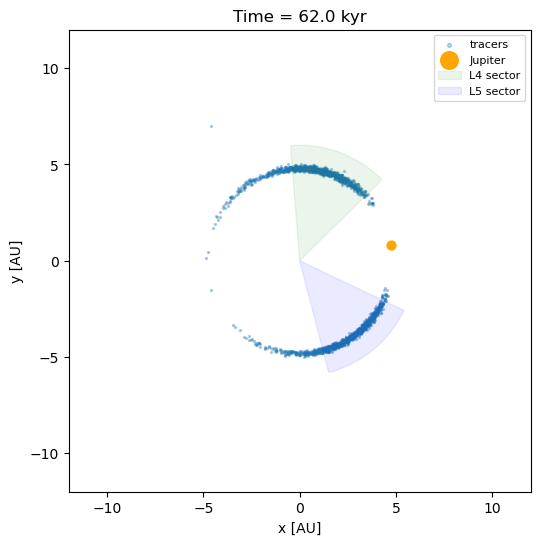

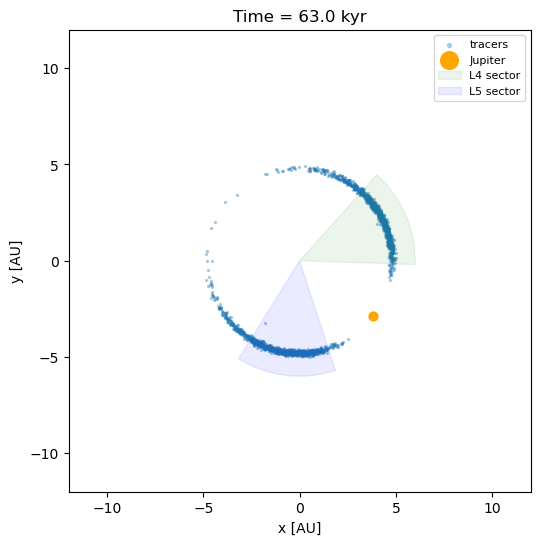

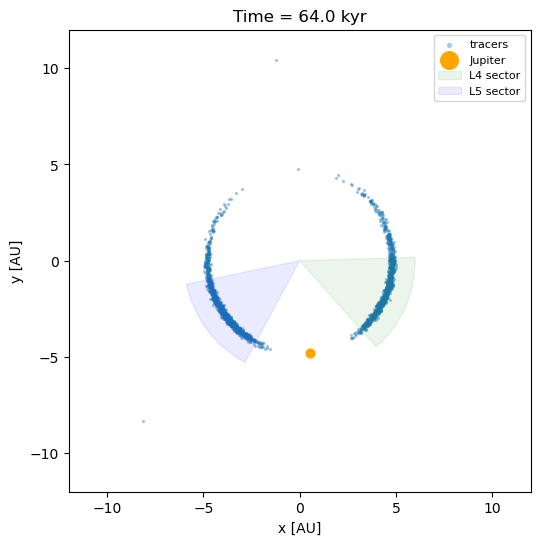

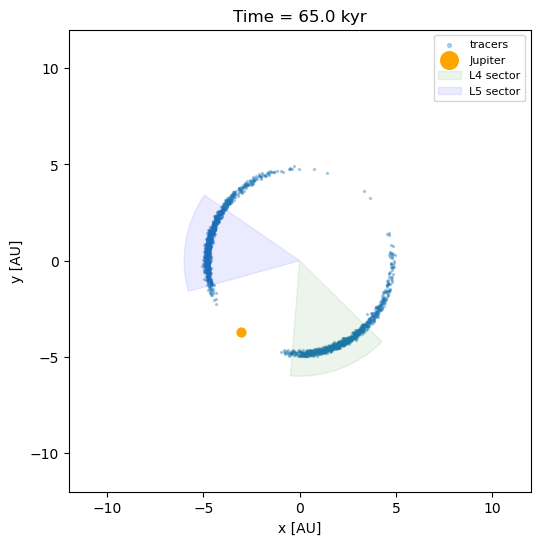

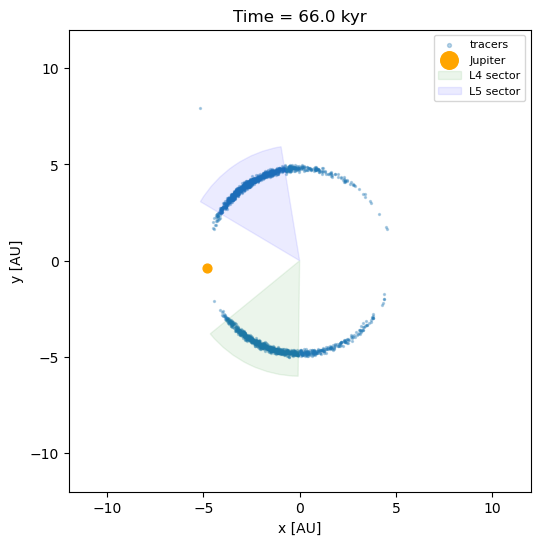

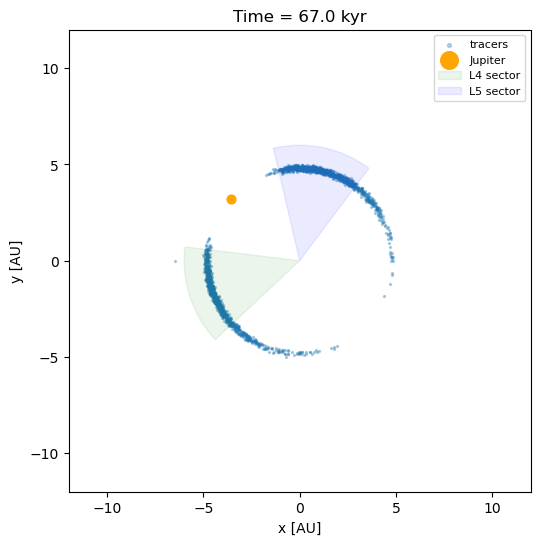

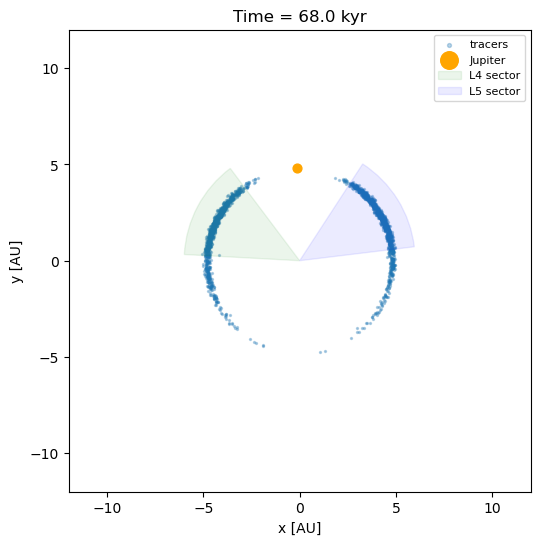

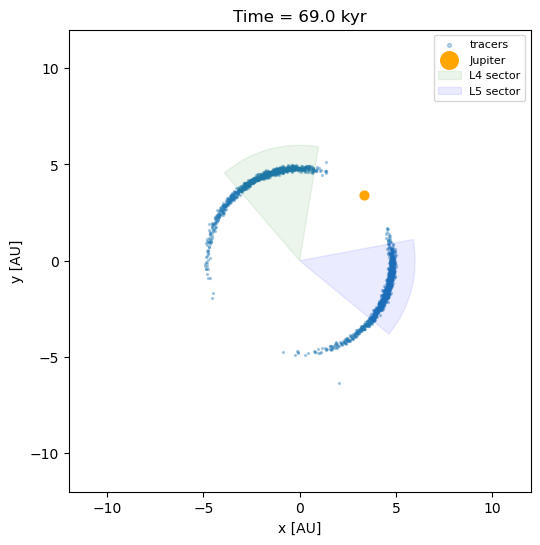

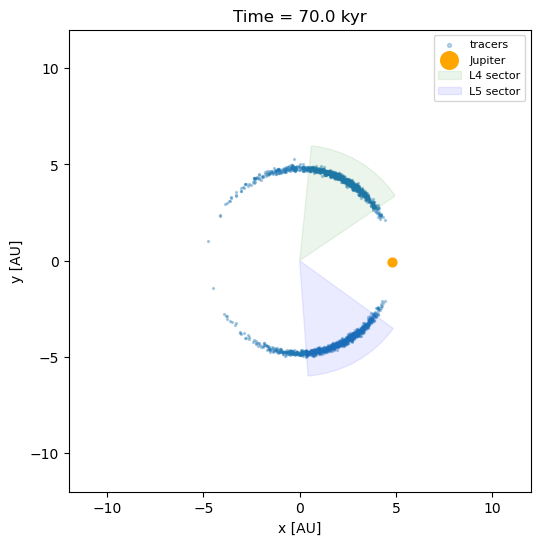

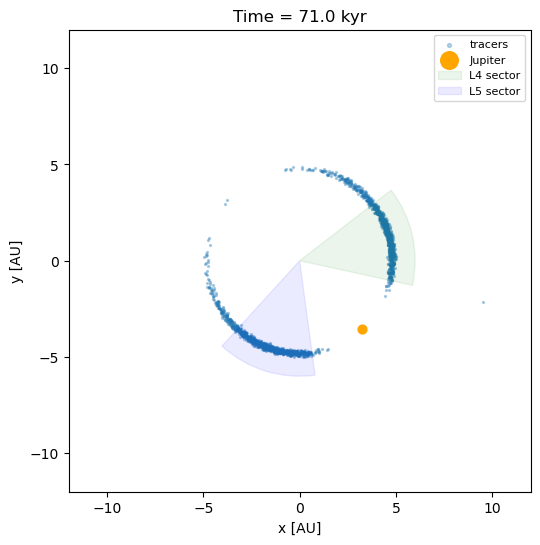

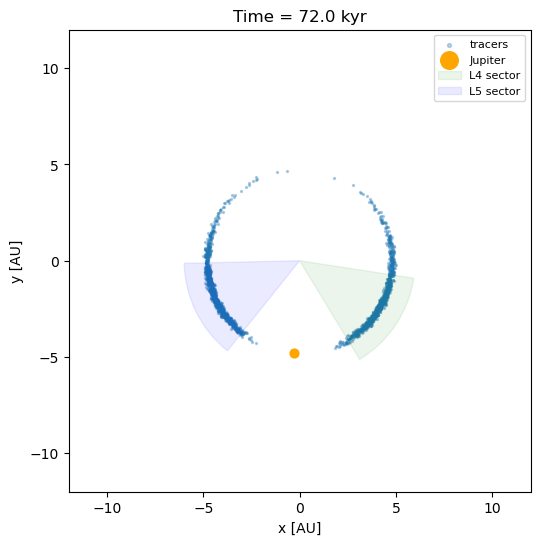

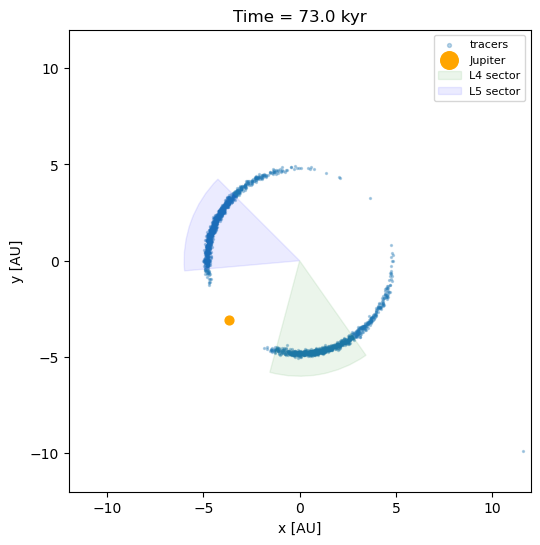

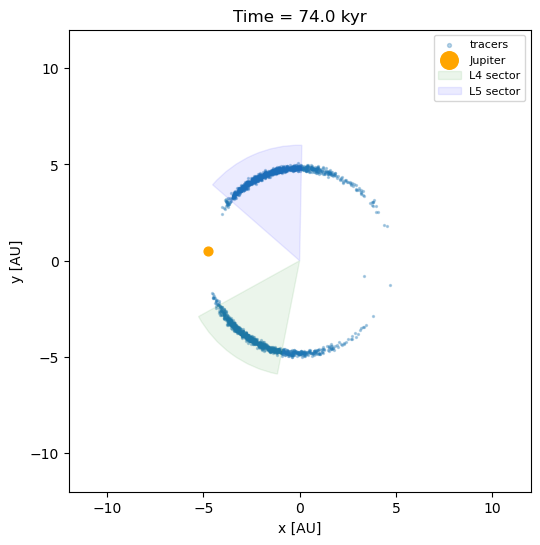

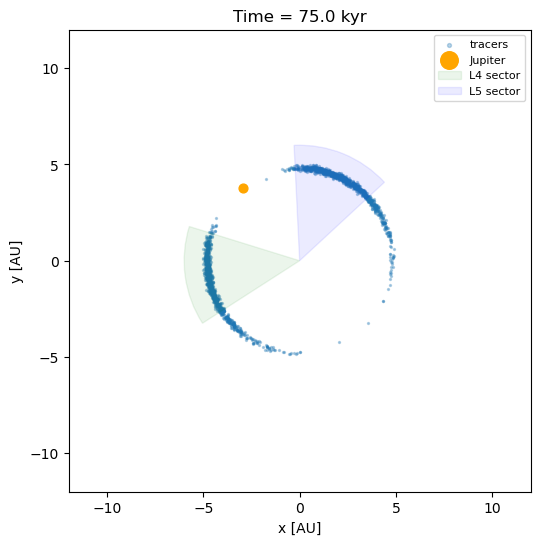

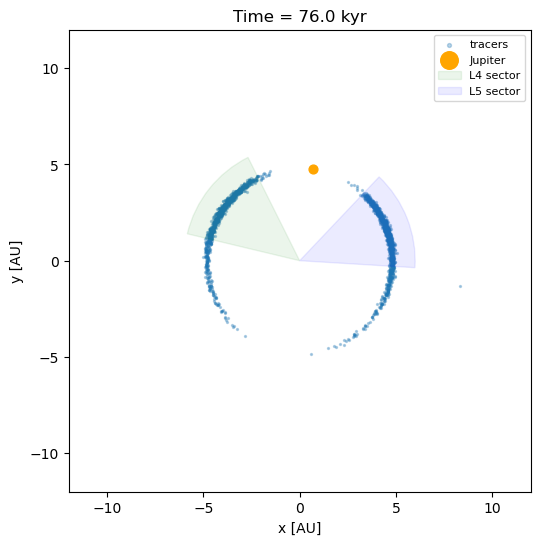

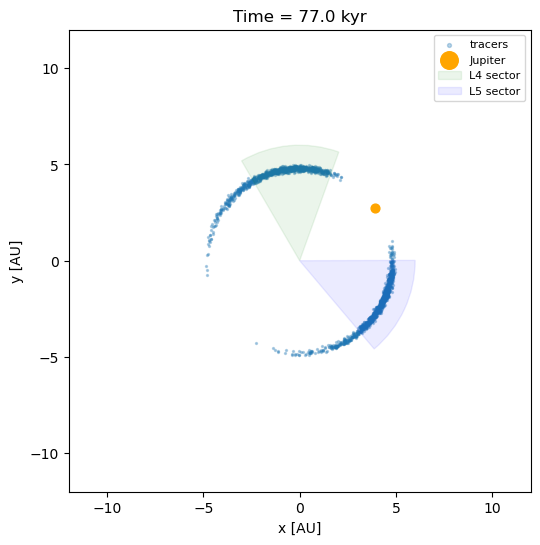

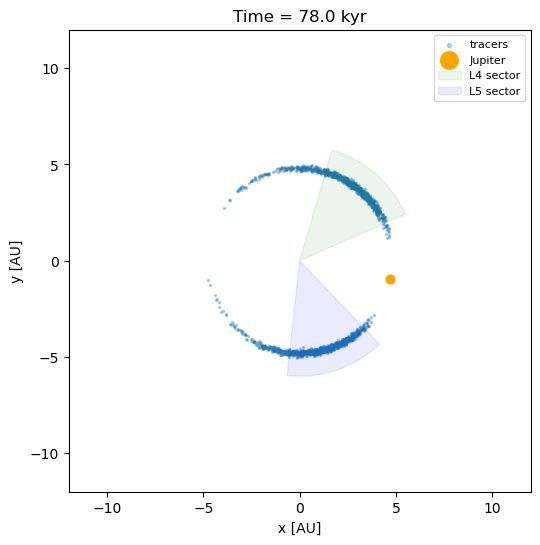

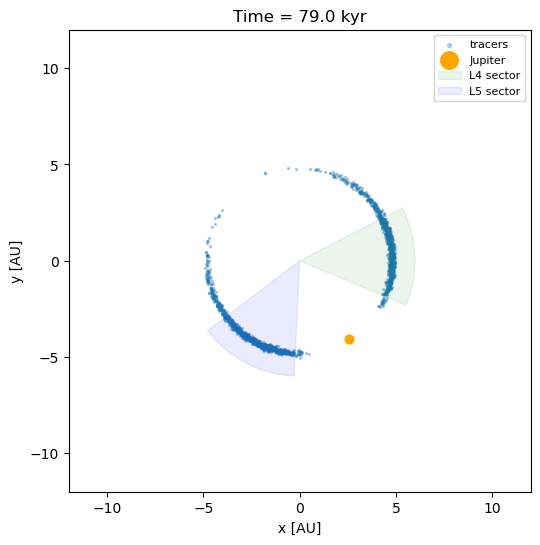

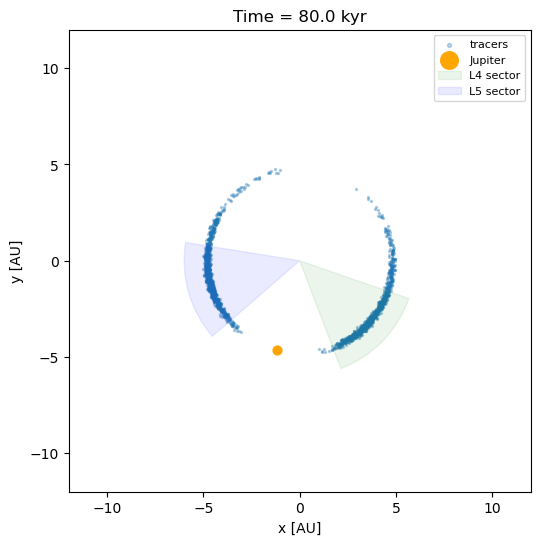

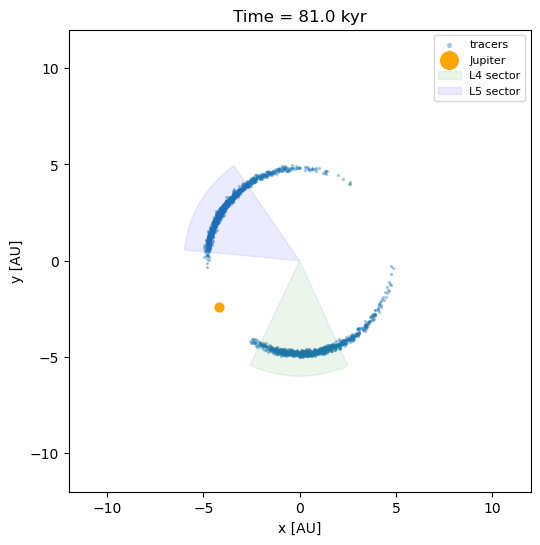

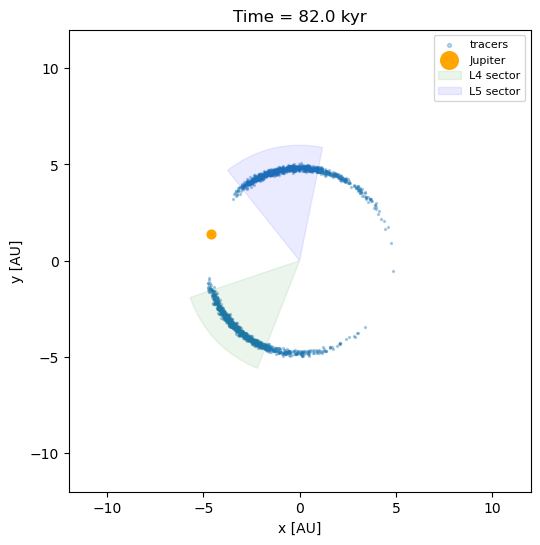

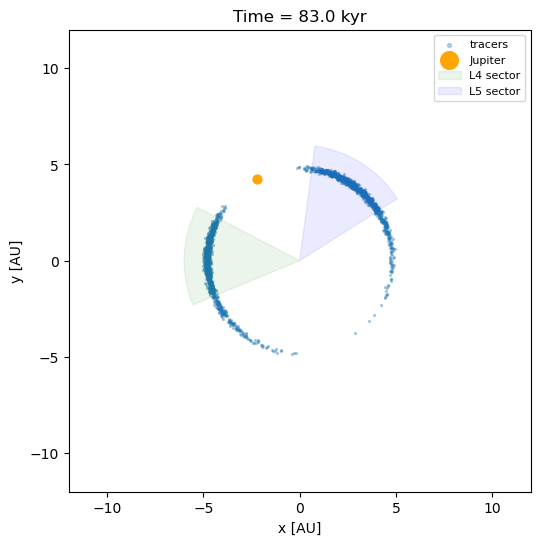

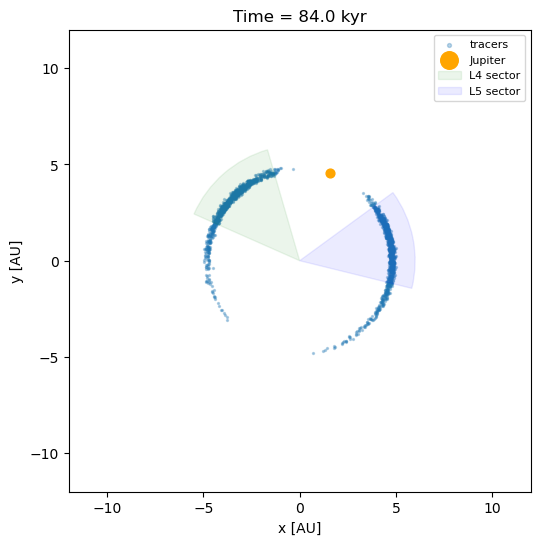

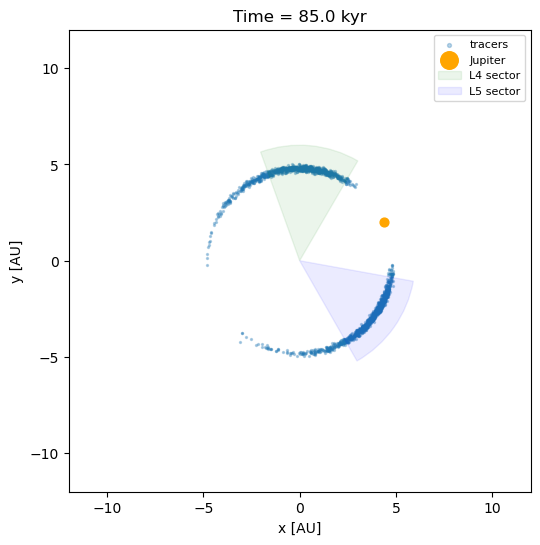

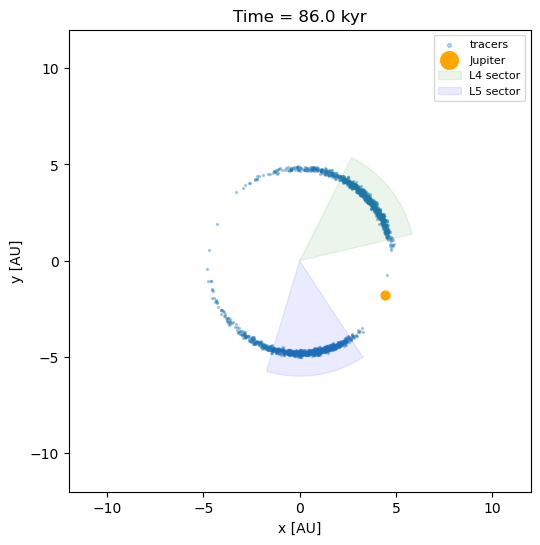

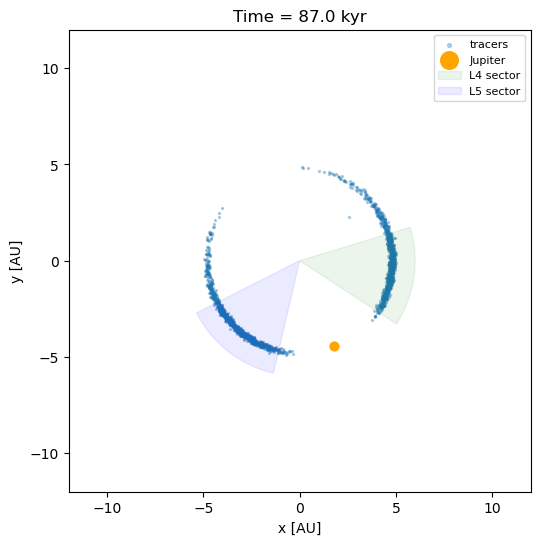

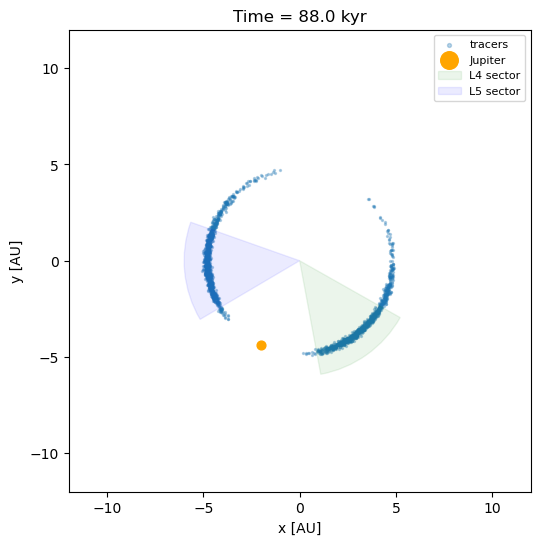

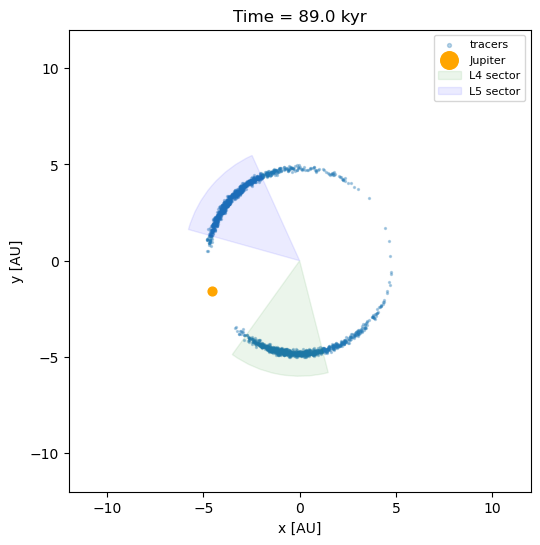

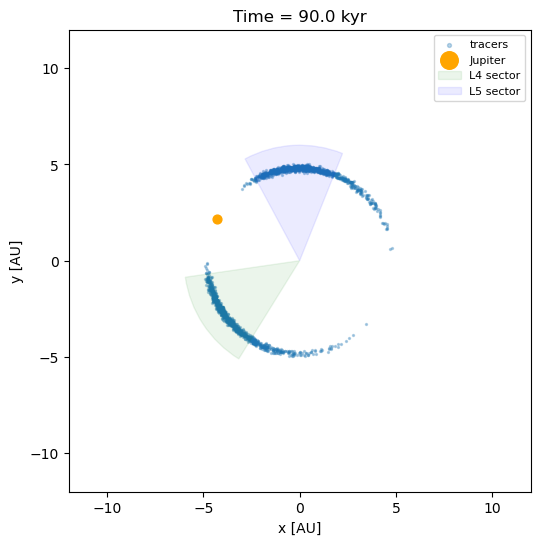

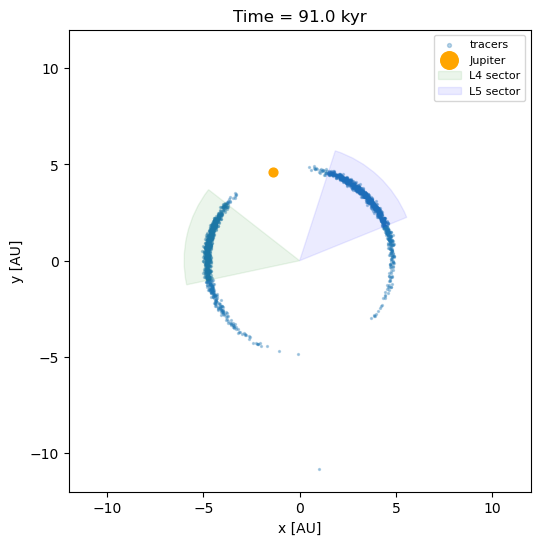

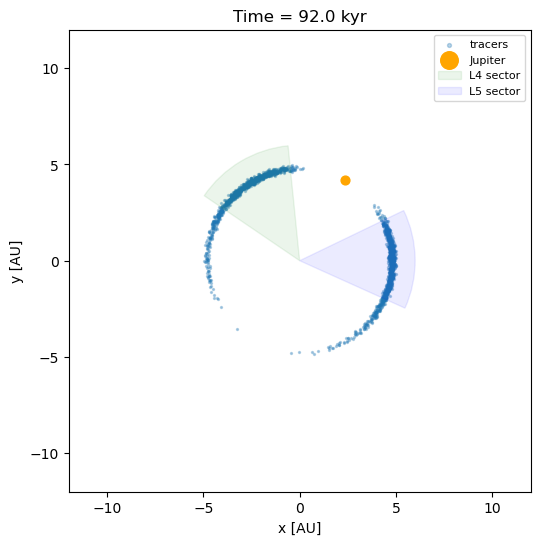

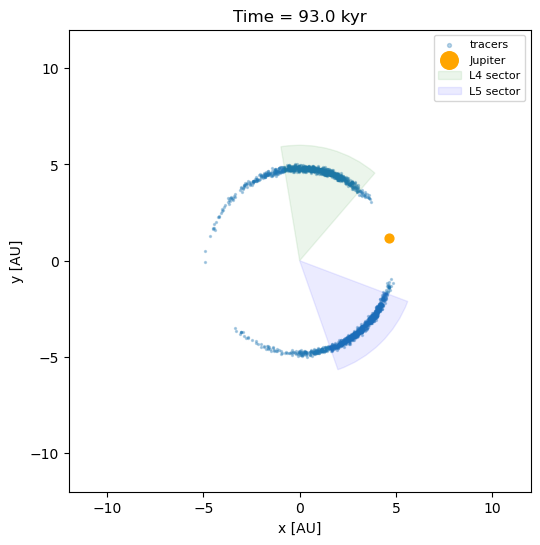

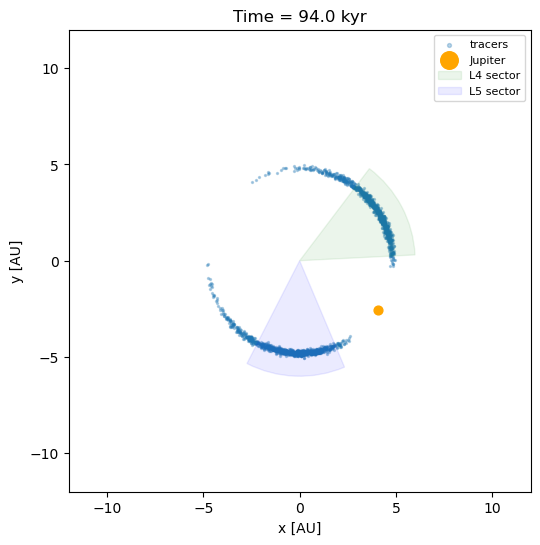

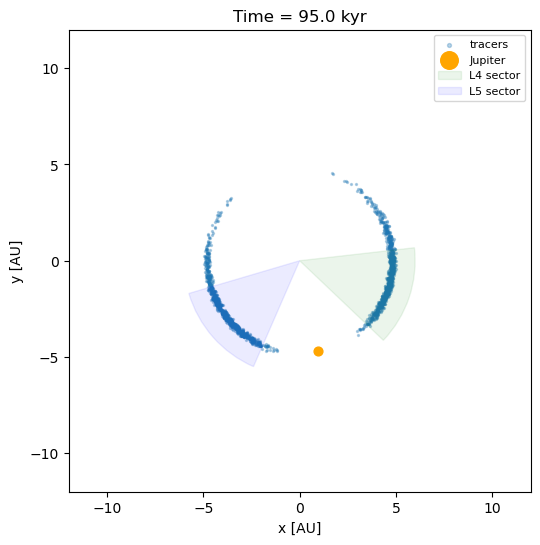

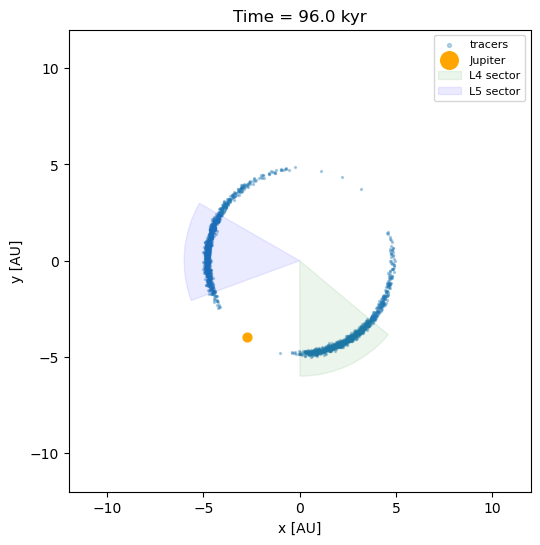

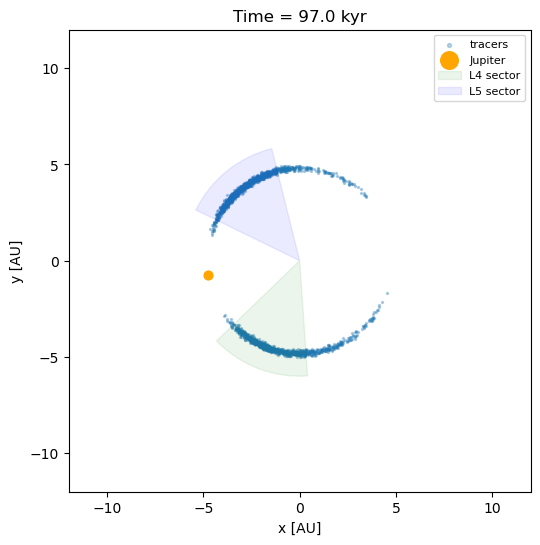

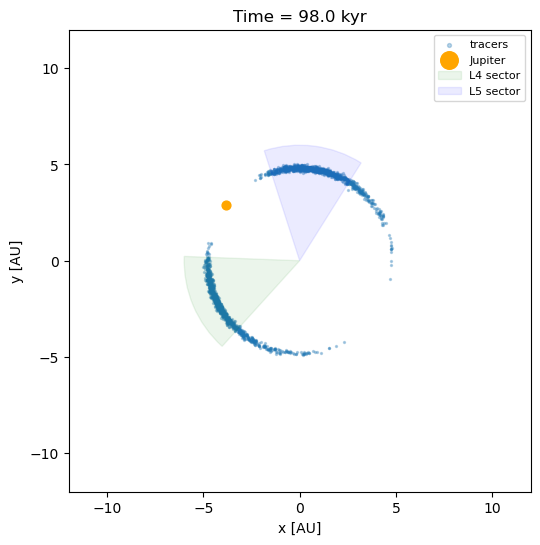

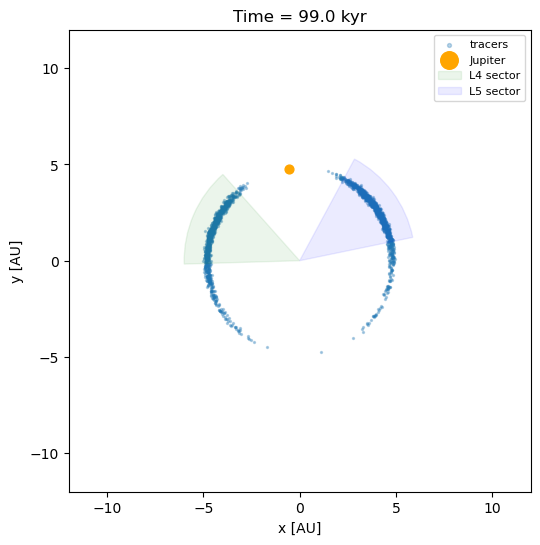

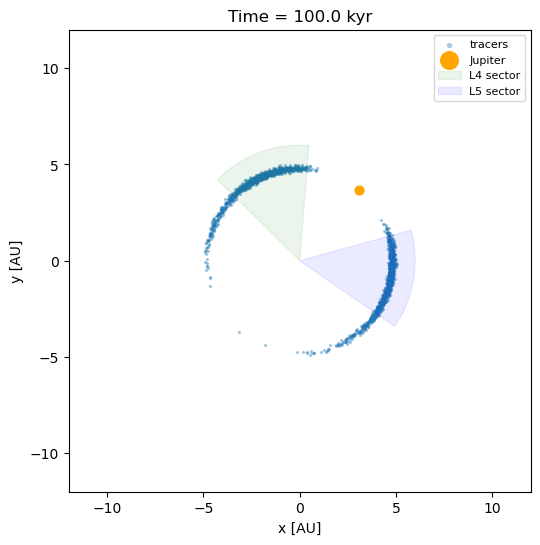

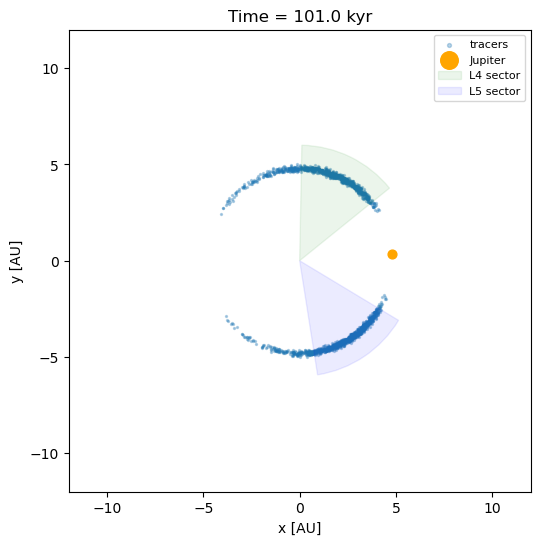

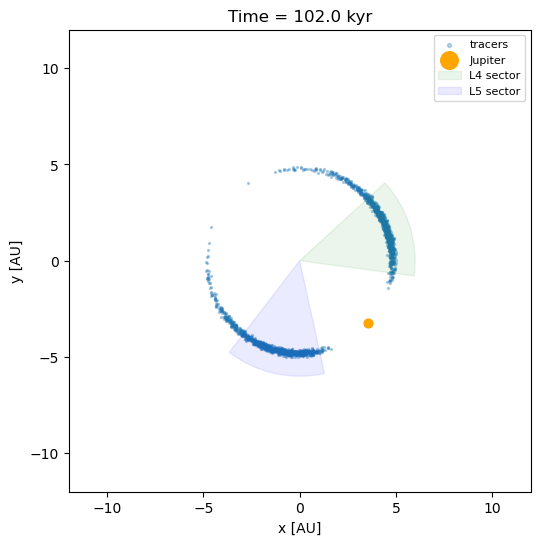

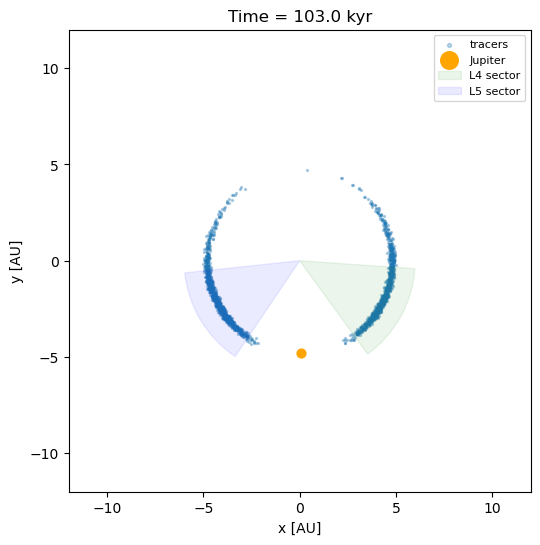

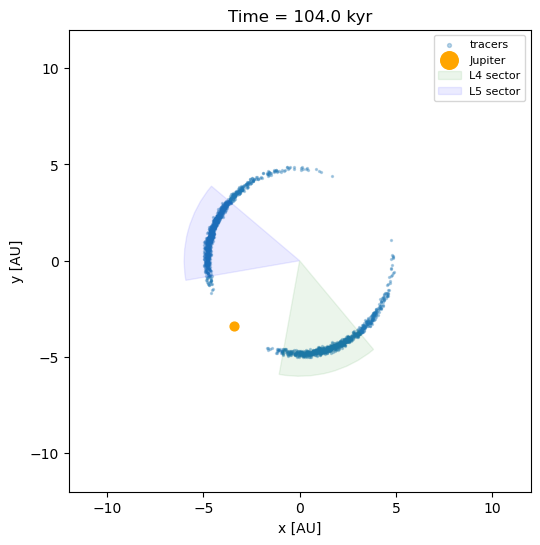

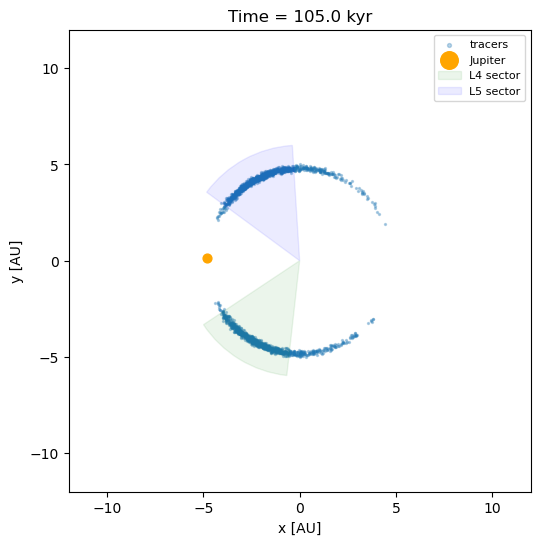

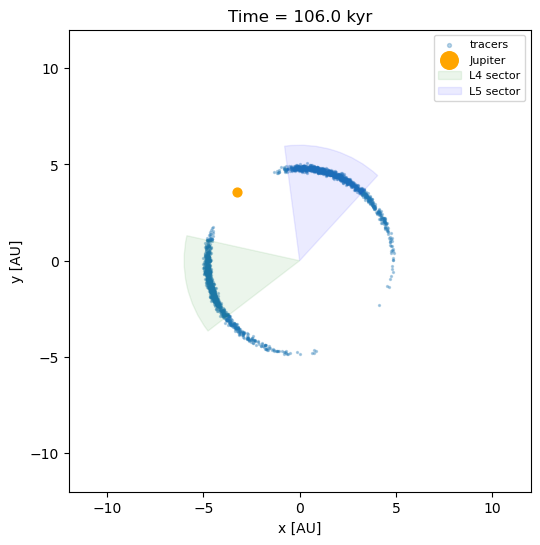

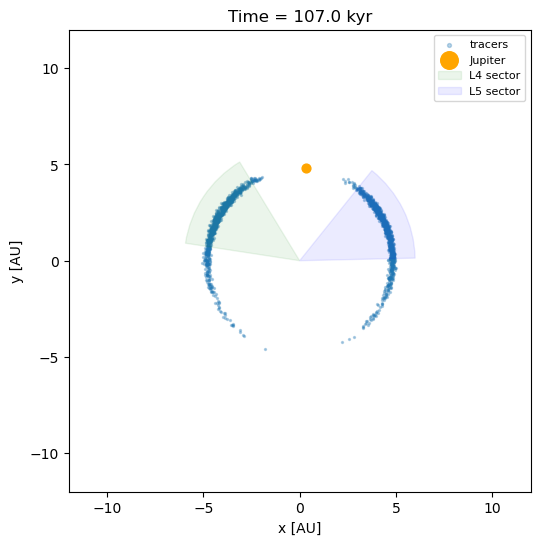

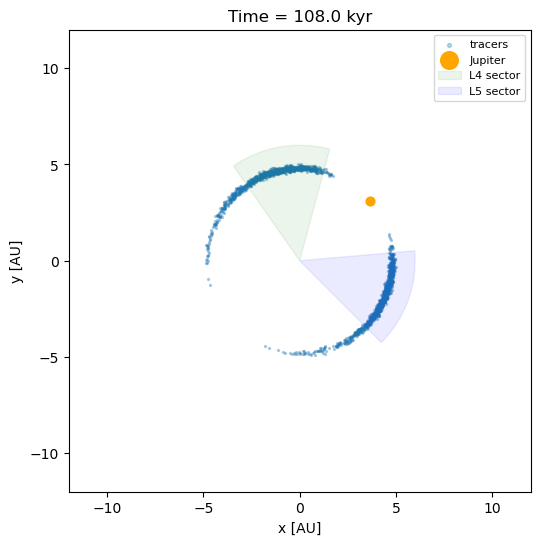

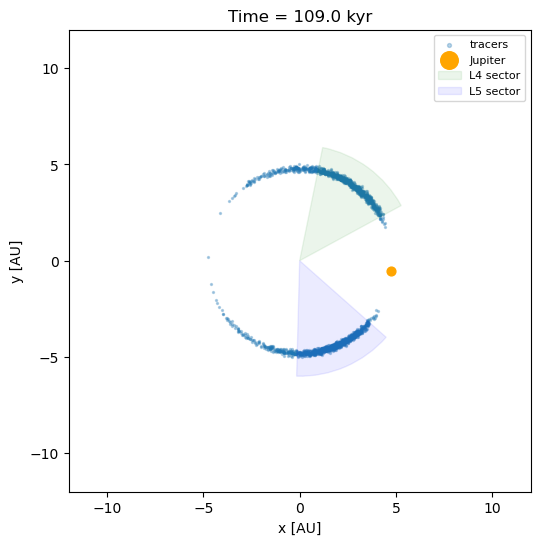

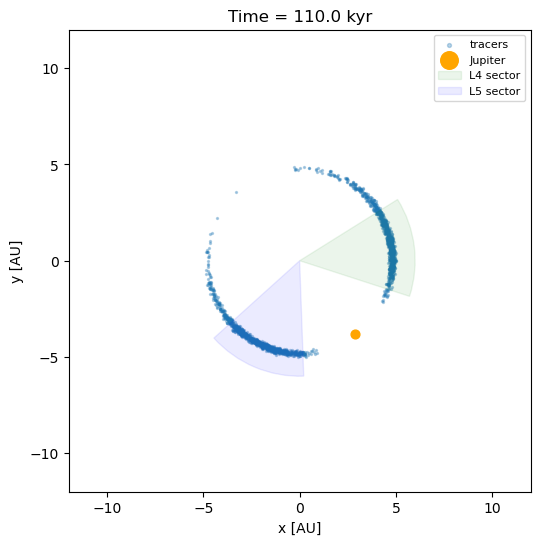

In [10]:
# 2D tracer distribution every snapshot with L4/L5 sectors
from matplotlib.patches import Wedge
times_kyr = times.value_in(units.kyr)
for ti, t in enumerate(times):
    fig, ax = plt.subplots(figsize=(6,6))
    xs = np.array(snapshots[ti][0])
    ys = np.array(snapshots[ti][1])
    ax.scatter(xs, ys, s=2, alpha=0.3, label='tracers')
    # mark Jupiter
    # per-snapshot Jupiter
    jup_x = jup_xs[ti]
    jup_y = jup_ys[ti]
    jup = massive_bodies[massive_bodies.name=="Jupiter"][0]
    ax.scatter([jup_x], [jup_y], color="orange", s=40, label="Jupiter")
    # L4/L5 wedges centered at +/-60 deg from Jupiter
    lambda_j = np.arctan2(jup_y, jup_x)
    # convert to degrees for wedges
    lam_deg = np.degrees(lambda_j)
    wedge_half = 25
    wedges = [Wedge((0,0), 6.0, lam_deg+60-wedge_half, lam_deg+60+wedge_half, alpha=0.08, color='green', label='L4 sector'),
              Wedge((0,0), 6.0, lam_deg-60-wedge_half, lam_deg-60+wedge_half, alpha=0.08, color='blue', label='L5 sector')]
    for w in wedges:
        ax.add_patch(w)
    ax.set_xlim(-12,12)
    ax.set_ylim(-12,12)
    ax.set_xlabel('x [AU]')
    ax.set_ylabel('y [AU]')
    ax.set_title(f'Time = {times_kyr[ti]:.1f} kyr')
    ax.legend(loc='upper right', markerscale=2, fontsize=8)
    ax.set_aspect('equal')
    plt.show()


Notes:
- This uses a simplified tracer drift (no self-gravity) and a relatively small `BRIDGE_DT` to resolve co-orbitals. If it runs too slowly, relax `BRIDGE_DT` to 0.05 yr and `HUAYNO_TSTEP_PARAM` to 0.02, but watch stability of L4/L5.
- Increase `N_TRACERS` and `BURNIN_TIME` once you confirm Trojans/Greeks form. For a more accurate run, migrate tracers inside Huayno (slower) or reintroduce the two-bridge setup from `solar_drift.ipynb` where tracers feel kicks from Huayno without being integrated by it.

In [11]:
# --- Post-run analysis: Jupiter a(t), fit da/dt, and thin snapshots to 10 kyr ---

import numpy as np

# 1) Jupiter semimajor axis history (approx a≈r; jup_xs/jup_ys are plain AU floats)
jup_a_au = np.hypot(np.array(jup_xs, dtype=float), np.array(jup_ys, dtype=float))
times_kyr = np.array([t.value_in(units.kyr) for t in times], dtype=float)

# 2) fit a linear trend over the migration window to infer effective tau
t_start = T_START_JUMP.value_in(units.kyr)
t_stop = T_JUMP_STOP.value_in(units.kyr)
mask = (times_kyr >= t_start) & (times_kyr <= t_stop)
if mask.sum() >= 2:
    coeffs = np.polyfit(times_kyr[mask], jup_a_au[mask], 1)  # slope, intercept
    slope_au_per_kyr = coeffs[0]
    a_mid = 0.5 * (JUPITER_A_INIT + JUPITER_A_FINAL).value_in(units.AU)
    tau_eff_kyr = a_mid / slope_au_per_kyr if slope_au_per_kyr != 0 else np.inf
    print(f"Linear fit slope: {slope_au_per_kyr:.4f} AU/kyr")
    print(f"Effective tau_a ~ {tau_eff_kyr:.1f} kyr")
else:
    print("Not enough points in migration window to fit a(t).")

# 3) thin snapshots to every 10 kyr
thin_step_kyr = 10.0
thin_times, thin_ratios, thin_n4, thin_n5 = [], [], [], []
thin_jup_x, thin_jup_y, thin_snapshots = [], [], []
next_mark = 0.0
for t, r, n4, n5, jx, jy, snap in zip(times_kyr, ratios, n4s, n5s, jup_xs, jup_ys, snapshots):
    if t >= next_mark - 1e-6:
        thin_times.append(t)
        thin_ratios.append(r)
        thin_n4.append(n4)
        thin_n5.append(n5)
        thin_jup_x.append(jx)
        thin_jup_y.append(jy)
        thin_snapshots.append(snap)
        next_mark += thin_step_kyr

print(f"Thinned snapshots to {len(thin_times)} points (every {thin_step_kyr} kyr).")



Linear fit slope: -0.0000 AU/kyr
Effective tau_a ~ -677522.2 kyr
Thinned snapshots to 12 points (every 10.0 kyr).
